# Autoencoder Content-Based Recommender

In [1]:
from comet_ml import Experiment
experiment = Experiment(api_key="ummagUWZ5eIZzmhPtFkA8oopu")

COMET WARNING: As you are running in a Jupyter environment, you will need to call `experiment.end()` when finished to ensure all metrics and code are logged before exiting.
[codecarbon INFO @ 19:12:21] [setup] RAM Tracking...
[codecarbon INFO @ 19:12:21] [setup] GPU Tracking...
[codecarbon INFO @ 19:12:21] No GPU found.
[codecarbon INFO @ 19:12:21] [setup] CPU Tracking...
[codecarbon WARNING @ 19:12:21] No CPU tracking mode found. Falling back on CPU constant mode.
[codecarbon WARNING @ 19:12:23] We saw that you have a Intel(R) Xeon(R) CPU E5-2630 v3 @ 2.40GHz but we don't know it. Please contact us.
[codecarbon INFO @ 19:12:23] CPU Model on constant consumption mode: Intel(R) Xeon(R) CPU E5-2630 v3 @ 2.40GHz
[codecarbon INFO @ 19:12:23] >>> Tracker's metadata:
[codecarbon INFO @ 19:12:23]   Platform system: Linux-5.4.0-147-generic-x86_64-with-glibc2.29
[codecarbon INFO @ 19:12:23]   Python version: 3.8.10
[codecarbon INFO @ 19:12:23]   Available RAM : 31.360 GB
[codecarbon INFO @ 19:1

In [2]:
from tqdm import tqdm
import time

import csv
import numpy as np
import pandas as pd
import scipy.sparse as sp

import matplotlib.pyplot as plt

from sklearn.model_selection import train_test_split
from sklearn.preprocessing import MinMaxScaler
from sklearn.metrics.pairwise import cosine_similarity 

import keras
import tensorflow as tf
from keras.callbacks import ModelCheckpoint
from keras.models import load_model
from sklearn.preprocessing import OneHotEncoder
from sklearn.metrics import confusion_matrix
from sklearn.metrics import f1_score
from sklearn.metrics import roc_auc_score

from keras.layers import (GlobalAveragePooling2D, Flatten, Dense, Dropout, Conv2D, Conv2DTranspose, BatchNormalization, AlphaDropout, MaxPooling2D, UpSampling2D, Rescaling, Resizing, LeakyReLU)
from keras.callbacks import EarlyStopping, ModelCheckpoint, ReduceLROnPlateau
from tensorflow.keras.optimizers import Adam, SGD
from keras import Sequential, Model

Matplotlib created a temporary config/cache directory at /tmp/matplotlib-sz7c9quk because the default path (/home/asadcor/.cache/matplotlib) is not a writable directory; it is highly recommended to set the MPLCONFIGDIR environment variable to a writable directory, in particular to speed up the import of Matplotlib and to better support multiprocessing.
2023-05-03 19:12:32.097017: W tensorflow/stream_executor/platform/default/dso_loader.cc:64] Could not load dynamic library 'libcudart.so.11.0'; dlerror: libcudart.so.11.0: cannot open shared object file: No such file or directory
2023-05-03 19:12:32.097082: I tensorflow/stream_executor/cuda/cudart_stub.cc:29] Ignore above cudart dlerror if you do not have a GPU set up on your machine.


## Part 1: Autoencoder

In [3]:
playlists_dataset_with_mood = pd.read_csv('working/playlists_dataset_with_mood.csv')

### Data cleaning

In [4]:
df_unique_songs = playlists_dataset_with_mood.drop_duplicates(['track_uri'])

df_tracks = df_unique_songs['track_uri']
df_track_names = df_unique_songs['track_name']

df_songs_clean = df_unique_songs.drop(columns=[
    'pid', 'pos', 'name', 'description', 'modified_at', 'num_tracks','num_albums','num_followers',
    'num_edits', 'artist_name', 'track_name','album_name', 'track_uri','album_release_date'])


mean_popularity = df_songs_clean['track_popularity'].mean()
df_songs_clean['track_popularity'] = df_songs_clean['track_popularity'].fillna(mean_popularity)

df_songs_clean['track_explicit'] = df_songs_clean['track_explicit'].fillna(False)

df_songs_clean['track_explicit'] = df_songs_clean['track_explicit'].astype(int)

In [5]:
# encode the moods as one-hot vectors
one_hot_encoder = OneHotEncoder()
mood_encoded = one_hot_encoder.fit_transform(df_songs_clean[["mood"]])

# convert the encoded moods to a dataframe
mood_df = pd.DataFrame(mood_encoded.toarray(), columns=one_hot_encoder.get_feature_names(["mood"]))

# index reset
mood_df = mood_df.reset_index(drop=True)
df_songs_clean = df_songs_clean.reset_index(drop=True)

# concatenate the encoded moods to the original dataframe
df_songs_to_encode = pd.concat([df_songs_clean, mood_df], axis=1)

In [6]:
# mood_map = {'Energetic': np.array([0, 1]),'Calm': np.array([0, -1]),'Sad': np.array([-1, 0]),'Happy': np.array([1, 0]),'Anxious': np.array([-1, 1]),'Depression': np.array([-1, -1]),'Exuberance': np.array([1, 1]),'Contentment': np.array([1, -1])}
# df_songs_clean['mood'] = df_songs_clean['mood'].map(mood_map)

In [7]:
df_songs_to_encode = df_songs_to_encode.drop(columns=['mood'])
df_songs_to_encode.head(4)

,danceability,energy,key,loudness,mode,speechiness,acousticness,instrumentalness,liveness,valence,...,track_popularity,track_explicit,mood_Anxious,mood_Calm,mood_Contentment,mood_Depression,mood_Energetic,mood_Exuberance,mood_Happy,mood_Sad
0,0.674,0.413,2,-7.816,1,0.0274,0.836,0.000019,0.0980,0.503,...,68.0,0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
1,0.630,0.530,0,-7.259,1,0.0434,0.400,0.000000,0.1770,0.417,...,79.0,0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
2,0.456,0.636,1,-6.552,1,0.0432,0.462,0.000189,0.2520,0.492,...,33.0,0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0
3,0.586,0.128,7,-9.297,1,0.0496,0.963,0.000000,0.0858,0.371,...,69.0,0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0


In [8]:
df_songs_clean['mood'].unique()

array(['Anxious', 'Sad', 'Calm', 'Energetic', 'Exuberance', 'Depression',
       'Happy', 'Contentment'], dtype=object)

### Standardizing the data

In [9]:
scaler = MinMaxScaler()
scaler.fit(df_songs_to_encode)
songs_scaled = scaler.transform(df_songs_to_encode)

In [10]:
songs_scaled.shape

(268230, 23)

In [11]:
df_songs_scaled = pd.DataFrame(songs_scaled)
df_songs_scaled.head(4)

,0,1,2,3,4,5,6,7,8,9,...,13,14,15,16,17,18,19,20,21,22
0,0.680808,0.413,0.181818,0.807327,1.0,0.028277,0.839357,0.000019,0.0980,0.503,...,0.739130,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
1,0.636364,0.530,0.000000,0.815944,1.0,0.044788,0.401606,0.000000,0.1770,0.417,...,0.858696,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
2,0.460606,0.636,0.090909,0.826882,1.0,0.044582,0.463855,0.000189,0.2520,0.492,...,0.358696,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0
3,0.591919,0.128,0.636364,0.784415,1.0,0.051187,0.966867,0.000000,0.0858,0.371,...,0.750000,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0


In [12]:
train, val_test = train_test_split(songs_scaled, test_size=0.2, shuffle=True, random_state=12)
val, test = train_test_split(val_test, test_size=0.5, shuffle=True, random_state=12)

## Autoencoder design and training


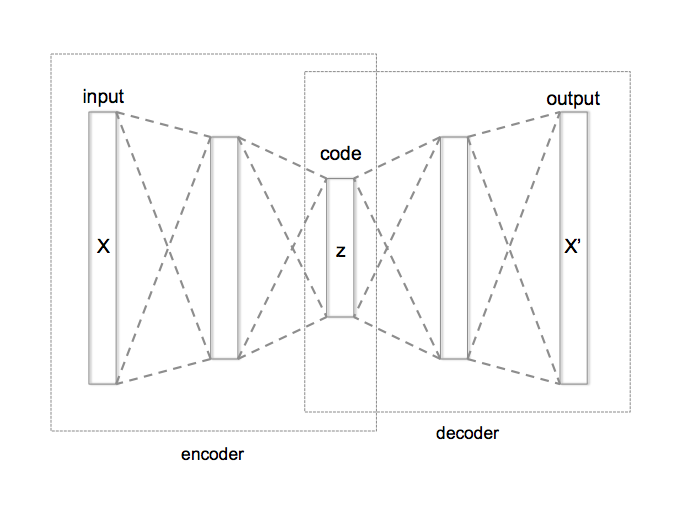
A well-trained autoencoder is capable to provide a good latent representation. This representation is quite different from the original data but it has all the information contained in the input layer.

https://datascience.stackexchange.com/questions/33338/autoencoder-for-features-selection

In [13]:
input_song = keras.layers.Input(shape=(23,))

# Encoder
x = Dense(128, activation='relu')(input_song)
x = BatchNormalization()(x)
x = LeakyReLU()(x)
x = Dropout(0.2)(x)

x = Dense(64, activation='relu')(x)
x = BatchNormalization()(x)
x = LeakyReLU()(x)
x = Dropout(0.2)(x)

x = Dense(32, activation='relu')(x)
x = BatchNormalization()(x)
x = LeakyReLU()(x)
x = Dropout(0.2)(x)

encoded = Dense(16, activation='relu')(x)

# Decoder
x = Dense(32, activation='relu')(encoded)
x = BatchNormalization()(x)
x = LeakyReLU()(x)
x = Dropout(0.2)(x)

x = Dense(64, activation='relu')(x)
x = BatchNormalization()(x)
x = LeakyReLU()(x)
x = Dropout(0.2)(x)

x = Dense(128, activation='relu')(x)
x = BatchNormalization()(x)
x = LeakyReLU()(x)
x = Dropout(0.2)(x)

decoded = Dense(23, activation='sigmoid')(x)

autoencoder_ = Model(inputs=input_song, outputs=decoded)

2023-05-03 19:12:40.408331: W tensorflow/stream_executor/platform/default/dso_loader.cc:64] Could not load dynamic library 'libcuda.so.1'; dlerror: libcuda.so.1: cannot open shared object file: No such file or directory
2023-05-03 19:12:40.408384: W tensorflow/stream_executor/cuda/cuda_driver.cc:269] failed call to cuInit: UNKNOWN ERROR (303)
2023-05-03 19:12:40.408410: I tensorflow/stream_executor/cuda/cuda_diagnostics.cc:156] kernel driver does not appear to be running on this host (JptHub01): /proc/driver/nvidia/version does not exist
2023-05-03 19:12:40.408646: I tensorflow/core/platform/cpu_feature_guard.cc:142] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  AVX2 FMA
To enable them in other operations, rebuild TensorFlow with the appropriate compiler flags.


In [14]:
# Compile model
autoencoder_.compile(optimizer=Adam(learning_rate=0.001),
              loss='mean_squared_error',
              metrics=['accuracy'])


# EarlyStopping,ReduceLROnPlateau, and ModelCheckpoint
early_stop = EarlyStopping(monitor='val_loss', patience=10, mode='min')
# reduce_lr = ReduceLROnPlateau(monitor='val_loss', factor=0.2, patience=3, min_lr=0.00001)

model_checkpoint_autoencoder = ModelCheckpoint('models/best_weights_autoencoder.h5',
                                       monitor='val_loss',
                                       save_best_only=True,
                                       mode='min')

In [15]:
# Train model
start_time = time.time()

trained_model_autoencoder_ = autoencoder_.fit(
    train, train,
    epochs=100,
    validation_data=(val, val),
    callbacks=[early_stop, model_checkpoint_autoencoder],
    verbose=1)

end_time = time.time()
print('Training time: ' + str(round((end_time-start_time)/60,2)) + " minutes")

COMET INFO: Ignoring automatic log_parameter('verbose') because 'keras:verbose' is in COMET_LOGGING_PARAMETERS_IGNORE
2023-05-03 19:12:40.754080: I tensorflow/compiler/mlir/mlir_graph_optimization_pass.cc:185] None of the MLIR Optimization Passes are enabled (registered 2)


Epoch 1/100


COMET INFO: ignoring tensorflow summary log of metrics because of keras; set `comet_ml.loggers.tensorboard_logger.LOG_METRICS = True` to override
[codecarbon INFO @ 19:12:41] Energy consumed for RAM : 0.000049 kWh. RAM Power : 11.759872913360596 W
[codecarbon INFO @ 19:12:41] Energy consumed for all CPUs : 0.000177 kWh. All CPUs Power : 42.5 W
[codecarbon INFO @ 19:12:41] 0.000226 kWh of electricity used since the begining.


4132/6706 [=================>............] - ETA: 8s - loss: 0.0248 - accuracy: 0.5765

[codecarbon INFO @ 19:12:56] Energy consumed for RAM : 0.000098 kWh. RAM Power : 11.759872913360596 W
[codecarbon INFO @ 19:12:56] Energy consumed for all CPUs : 0.000354 kWh. All CPUs Power : 42.5 W
[codecarbon INFO @ 19:12:56] 0.000452 kWh of electricity used since the begining.


6706/6706 [==============================] - 26s 4ms/step - loss: 0.0210 - accuracy: 0.5766 - val_loss: 0.0092 - val_accuracy: 0.4674
Epoch 2/100
1305/6706 [====>.........................] - ETA: 18s - loss: 0.0134 - accuracy: 0.5694

[codecarbon INFO @ 19:13:11] Energy consumed for RAM : 0.000147 kWh. RAM Power : 11.759872913360596 W
[codecarbon INFO @ 19:13:11] Energy consumed for all CPUs : 0.000531 kWh. All CPUs Power : 42.5 W


1321/6706 [====>.........................] - ETA: 18s - loss: 0.0134 - accuracy: 0.5694

[codecarbon INFO @ 19:13:11] 0.000678 kWh of electricity used since the begining.


5811/6706 [========================>.....] - ETA: 2s - loss: 0.0126 - accuracy: 0.5902

[codecarbon INFO @ 19:13:26] Energy consumed for RAM : 0.000196 kWh. RAM Power : 11.759872913360596 W
[codecarbon INFO @ 19:13:26] Energy consumed for all CPUs : 0.000708 kWh. All CPUs Power : 42.5 W
[codecarbon INFO @ 19:13:26] 0.000904 kWh of electricity used since the begining.


6706/6706 [==============================] - 23s 3ms/step - loss: 0.0124 - accuracy: 0.5950 - val_loss: 0.0079 - val_accuracy: 0.6704
Epoch 3/100
3293/6706 [=============>................] - ETA: 11s - loss: 0.0113 - accuracy: 0.6218

[codecarbon INFO @ 19:13:41] Energy consumed for RAM : 0.000245 kWh. RAM Power : 11.759872913360596 W
[codecarbon INFO @ 19:13:41] Energy consumed for all CPUs : 0.000885 kWh. All CPUs Power : 42.5 W
[codecarbon INFO @ 19:13:41] 0.001130 kWh of electricity used since the begining.


6706/6706 [==============================] - 23s 3ms/step - loss: 0.0110 - accuracy: 0.6386 - val_loss: 0.0067 - val_accuracy: 0.7580
Epoch 4/100
 747/6706 [==>...........................] - ETA: 19s - loss: 0.0102 - accuracy: 0.6583

[codecarbon INFO @ 19:13:56] Energy consumed for RAM : 0.000294 kWh. RAM Power : 11.759872913360596 W
[codecarbon INFO @ 19:13:56] Energy consumed for all CPUs : 0.001062 kWh. All CPUs Power : 42.5 W
[codecarbon INFO @ 19:13:56] 0.001356 kWh of electricity used since the begining.


5206/6706 [======================>.......] - ETA: 5s - loss: 0.0098 - accuracy: 0.6646

[codecarbon INFO @ 19:14:11] Energy consumed for RAM : 0.000343 kWh. RAM Power : 11.759872913360596 W
[codecarbon INFO @ 19:14:11] Energy consumed for all CPUs : 0.001239 kWh. All CPUs Power : 42.5 W


5222/6706 [======================>.......] - ETA: 4s - loss: 0.0098 - accuracy: 0.6647

[codecarbon INFO @ 19:14:11] 0.001582 kWh of electricity used since the begining.


6706/6706 [==============================] - 23s 3ms/step - loss: 0.0097 - accuracy: 0.6694 - val_loss: 0.0056 - val_accuracy: 0.6923
Epoch 5/100
2632/6706 [==========>...................] - ETA: 13s - loss: 0.0090 - accuracy: 0.6996

[codecarbon INFO @ 19:14:26] Energy consumed for RAM : 0.000392 kWh. RAM Power : 11.759872913360596 W
[codecarbon INFO @ 19:14:26] Energy consumed for all CPUs : 0.001416 kWh. All CPUs Power : 42.5 W
[codecarbon INFO @ 19:14:26] 0.001808 kWh of electricity used since the begining.


6706/6706 [==============================] - 23s 4ms/step - loss: 0.0089 - accuracy: 0.6937 - val_loss: 0.0051 - val_accuracy: 0.6575
Epoch 6/100
 118/6706 [..............................] - ETA: 23s - loss: 0.0087 - accuracy: 0.6941

[codecarbon INFO @ 19:14:41] Energy consumed for RAM : 0.000441 kWh. RAM Power : 11.759872913360596 W
[codecarbon INFO @ 19:14:41] Energy consumed for all CPUs : 0.001593 kWh. All CPUs Power : 42.5 W
[codecarbon INFO @ 19:14:41] 0.002034 kWh of electricity used since the begining.


4592/6706 [===================>..........] - ETA: 7s - loss: 0.0085 - accuracy: 0.7025

[codecarbon INFO @ 19:14:56] Energy consumed for RAM : 0.000490 kWh. RAM Power : 11.759872913360596 W
[codecarbon INFO @ 19:14:56] Energy consumed for all CPUs : 0.001771 kWh. All CPUs Power : 42.5 W
[codecarbon INFO @ 19:14:56] 0.002260 kWh of electricity used since the begining.


6706/6706 [==============================] - 24s 4ms/step - loss: 0.0084 - accuracy: 0.6993 - val_loss: 0.0048 - val_accuracy: 0.6758
Epoch 7/100
2011/6706 [=======>......................] - ETA: 15s - loss: 0.0081 - accuracy: 0.7114

[codecarbon INFO @ 19:15:11] Energy consumed for RAM : 0.000539 kWh. RAM Power : 11.759872913360596 W
[codecarbon INFO @ 19:15:11] Energy consumed for all CPUs : 0.001948 kWh. All CPUs Power : 42.5 W
[codecarbon INFO @ 19:15:11] 0.002486 kWh of electricity used since the begining.


6533/6706 [============================>.] - ETA: 0s - loss: 0.0078 - accuracy: 0.7125

[codecarbon INFO @ 19:15:26] Energy consumed for RAM : 0.000588 kWh. RAM Power : 11.759872913360596 W
[codecarbon INFO @ 19:15:26] Energy consumed for all CPUs : 0.002125 kWh. All CPUs Power : 42.5 W
[codecarbon INFO @ 19:15:26] 0.002712 kWh of electricity used since the begining.


6706/6706 [==============================] - 24s 4ms/step - loss: 0.0078 - accuracy: 0.7124 - val_loss: 0.0042 - val_accuracy: 0.6675
Epoch 8/100
3943/6706 [================>.............] - ETA: 9s - loss: 0.0075 - accuracy: 0.7078

[codecarbon INFO @ 19:15:41] Energy consumed for RAM : 0.000637 kWh. RAM Power : 11.759872913360596 W
[codecarbon INFO @ 19:15:41] Energy consumed for all CPUs : 0.002302 kWh. All CPUs Power : 42.5 W
[codecarbon INFO @ 19:15:41] 0.002938 kWh of electricity used since the begining.


6706/6706 [==============================] - 23s 3ms/step - loss: 0.0074 - accuracy: 0.7065 - val_loss: 0.0039 - val_accuracy: 0.6883
Epoch 9/100
1393/6706 [=====>........................] - ETA: 17s - loss: 0.0072 - accuracy: 0.7025

[codecarbon INFO @ 19:15:56] Energy consumed for RAM : 0.000686 kWh. RAM Power : 11.759872913360596 W
[codecarbon INFO @ 19:15:56] Energy consumed for all CPUs : 0.002479 kWh. All CPUs Power : 42.5 W
[codecarbon INFO @ 19:15:56] 0.003165 kWh of electricity used since the begining.


5795/6706 [========================>.....] - ETA: 3s - loss: 0.0071 - accuracy: 0.6993

[codecarbon INFO @ 19:16:11] Energy consumed for RAM : 0.000735 kWh. RAM Power : 11.759872913360596 W
[codecarbon INFO @ 19:16:11] Energy consumed for all CPUs : 0.002656 kWh. All CPUs Power : 42.5 W
[codecarbon INFO @ 19:16:11] 0.003391 kWh of electricity used since the begining.


6706/6706 [==============================] - 24s 4ms/step - loss: 0.0071 - accuracy: 0.6970 - val_loss: 0.0036 - val_accuracy: 0.7772
Epoch 10/100
3087/6706 [============>.................] - ETA: 12s - loss: 0.0070 - accuracy: 0.7105

[codecarbon INFO @ 19:16:26] Energy consumed for RAM : 0.000784 kWh. RAM Power : 11.759872913360596 W
[codecarbon INFO @ 19:16:26] Energy consumed for all CPUs : 0.002833 kWh. All CPUs Power : 42.5 W
[codecarbon INFO @ 19:16:26] 0.003617 kWh of electricity used since the begining.


6706/6706 [==============================] - 24s 4ms/step - loss: 0.0069 - accuracy: 0.7183 - val_loss: 0.0035 - val_accuracy: 0.8077
Epoch 11/100
 472/6706 [=>............................] - ETA: 21s - loss: 0.0067 - accuracy: 0.7205

[codecarbon INFO @ 19:16:41] Energy consumed for RAM : 0.000833 kWh. RAM Power : 11.759872913360596 W
[codecarbon INFO @ 19:16:41] Energy consumed for all CPUs : 0.003010 kWh. All CPUs Power : 42.5 W
[codecarbon INFO @ 19:16:41] 0.003843 kWh of electricity used since the begining.


4876/6706 [====================>.........] - ETA: 6s - loss: 0.0068 - accuracy: 0.7227

[codecarbon INFO @ 19:16:56] Energy consumed for RAM : 0.000882 kWh. RAM Power : 11.759872913360596 W
[codecarbon INFO @ 19:16:56] Energy consumed for all CPUs : 0.003187 kWh. All CPUs Power : 42.5 W
[codecarbon INFO @ 19:16:56] 0.004069 kWh of electricity used since the begining.


6706/6706 [==============================] - 24s 4ms/step - loss: 0.0068 - accuracy: 0.7198 - val_loss: 0.0034 - val_accuracy: 0.7888
Epoch 12/100
2223/6706 [========>.....................] - ETA: 15s - loss: 0.0067 - accuracy: 0.7326

[codecarbon INFO @ 19:17:11] Energy consumed for RAM : 0.000931 kWh. RAM Power : 11.759872913360596 W
[codecarbon INFO @ 19:17:11] Energy consumed for all CPUs : 0.003364 kWh. All CPUs Power : 42.5 W
[codecarbon INFO @ 19:17:11] 0.004295 kWh of electricity used since the begining.


6649/6706 [============================>.] - ETA: 0s - loss: 0.0067 - accuracy: 0.7230

[codecarbon INFO @ 19:17:26] Energy consumed for RAM : 0.000980 kWh. RAM Power : 11.759872913360596 W
[codecarbon INFO @ 19:17:26] Energy consumed for all CPUs : 0.003541 kWh. All CPUs Power : 42.5 W
[codecarbon INFO @ 19:17:26] 0.004521 kWh of electricity used since the begining.


6706/6706 [==============================] - 24s 4ms/step - loss: 0.0067 - accuracy: 0.7231 - val_loss: 0.0033 - val_accuracy: 0.7897
Epoch 13/100
4108/6706 [=================>............] - ETA: 8s - loss: 0.0066 - accuracy: 0.7261

[codecarbon INFO @ 19:17:41] Energy consumed for RAM : 0.001029 kWh. RAM Power : 11.759872913360596 W
[codecarbon INFO @ 19:17:41] Energy consumed for all CPUs : 0.003718 kWh. All CPUs Power : 42.5 W
[codecarbon INFO @ 19:17:41] 0.004747 kWh of electricity used since the begining.


6706/6706 [==============================] - 24s 4ms/step - loss: 0.0066 - accuracy: 0.7267 - val_loss: 0.0033 - val_accuracy: 0.8375
Epoch 14/100
1472/6706 [=====>........................] - ETA: 17s - loss: 0.0065 - accuracy: 0.7352

[codecarbon INFO @ 19:17:56] Energy consumed for RAM : 0.001078 kWh. RAM Power : 11.759872913360596 W
[codecarbon INFO @ 19:17:56] Energy consumed for all CPUs : 0.003895 kWh. All CPUs Power : 42.5 W
[codecarbon INFO @ 19:17:56] 0.004973 kWh of electricity used since the begining.


5873/6706 [=========================>....] - ETA: 2s - loss: 0.0065 - accuracy: 0.7312

[codecarbon INFO @ 19:18:11] Energy consumed for RAM : 0.001127 kWh. RAM Power : 11.759872913360596 W
[codecarbon INFO @ 19:18:11] Energy consumed for all CPUs : 0.004072 kWh. All CPUs Power : 42.5 W
[codecarbon INFO @ 19:18:11] 0.005199 kWh of electricity used since the begining.


6706/6706 [==============================] - 24s 4ms/step - loss: 0.0065 - accuracy: 0.7320 - val_loss: 0.0031 - val_accuracy: 0.8622
Epoch 15/100
3283/6706 [=============>................] - ETA: 11s - loss: 0.0064 - accuracy: 0.7250

[codecarbon INFO @ 19:18:26] Energy consumed for RAM : 0.001176 kWh. RAM Power : 11.759872913360596 W
[codecarbon INFO @ 19:18:26] Energy consumed for all CPUs : 0.004249 kWh. All CPUs Power : 42.5 W
[codecarbon INFO @ 19:18:26] 0.005425 kWh of electricity used since the begining.


6706/6706 [==============================] - 24s 4ms/step - loss: 0.0064 - accuracy: 0.7306 - val_loss: 0.0031 - val_accuracy: 0.7714
Epoch 16/100
 693/6706 [==>...........................] - ETA: 20s - loss: 0.0064 - accuracy: 0.7301

[codecarbon INFO @ 19:18:41] Energy consumed for RAM : 0.001225 kWh. RAM Power : 11.759872913360596 W
[codecarbon INFO @ 19:18:41] Energy consumed for all CPUs : 0.004426 kWh. All CPUs Power : 42.5 W
[codecarbon INFO @ 19:18:41] 0.005651 kWh of electricity used since the begining.


5211/6706 [======================>.......] - ETA: 4s - loss: 0.0064 - accuracy: 0.7414

[codecarbon INFO @ 19:18:56] Energy consumed for RAM : 0.001274 kWh. RAM Power : 11.759872913360596 W


5227/6706 [======================>.......] - ETA: 4s - loss: 0.0064 - accuracy: 0.7415

[codecarbon INFO @ 19:18:56] Energy consumed for all CPUs : 0.004604 kWh. All CPUs Power : 42.5 W
[codecarbon INFO @ 19:18:56] 0.005877 kWh of electricity used since the begining.


6706/6706 [==============================] - 23s 3ms/step - loss: 0.0064 - accuracy: 0.7432 - val_loss: 0.0031 - val_accuracy: 0.8564
Epoch 17/100
2701/6706 [===========>..................] - ETA: 13s - loss: 0.0064 - accuracy: 0.7428

[codecarbon INFO @ 19:19:11] Energy consumed for RAM : 0.001323 kWh. RAM Power : 11.759872913360596 W
[codecarbon INFO @ 19:19:11] Energy consumed for all CPUs : 0.004781 kWh. All CPUs Power : 42.5 W
[codecarbon INFO @ 19:19:11] 0.006103 kWh of electricity used since the begining.


6706/6706 [==============================] - 24s 4ms/step - loss: 0.0064 - accuracy: 0.7365 - val_loss: 0.0031 - val_accuracy: 0.8290
Epoch 18/100
  13/6706 [..............................] - ETA: 29s - loss: 0.0063 - accuracy: 0.7308

[codecarbon INFO @ 19:19:26] Energy consumed for RAM : 0.001372 kWh. RAM Power : 11.759872913360596 W
[codecarbon INFO @ 19:19:26] Energy consumed for all CPUs : 0.004958 kWh. All CPUs Power : 42.5 W
[codecarbon INFO @ 19:19:26] 0.006329 kWh of electricity used since the begining.


4535/6706 [===================>..........] - ETA: 7s - loss: 0.0063 - accuracy: 0.7483

[codecarbon INFO @ 19:19:41] Energy consumed for RAM : 0.001421 kWh. RAM Power : 11.759872913360596 W
[codecarbon INFO @ 19:19:41] Energy consumed for all CPUs : 0.005135 kWh. All CPUs Power : 42.5 W
[codecarbon INFO @ 19:19:41] 0.006555 kWh of electricity used since the begining.


6706/6706 [==============================] - 24s 4ms/step - loss: 0.0063 - accuracy: 0.7471 - val_loss: 0.0031 - val_accuracy: 0.8369
Epoch 19/100
1896/6706 [=======>......................] - ETA: 16s - loss: 0.0062 - accuracy: 0.7456

[codecarbon INFO @ 19:19:56] Energy consumed for RAM : 0.001470 kWh. RAM Power : 11.759872913360596 W
[codecarbon INFO @ 19:19:56] Energy consumed for all CPUs : 0.005312 kWh. All CPUs Power : 42.5 W
[codecarbon INFO @ 19:19:56] 0.006781 kWh of electricity used since the begining.


6386/6706 [===========================>..] - ETA: 1s - loss: 0.0062 - accuracy: 0.7492

[codecarbon INFO @ 19:20:11] Energy consumed for RAM : 0.001519 kWh. RAM Power : 11.759872913360596 W
[codecarbon INFO @ 19:20:11] Energy consumed for all CPUs : 0.005489 kWh. All CPUs Power : 42.5 W
[codecarbon INFO @ 19:20:11] 0.007007 kWh of electricity used since the begining.


6706/6706 [==============================] - 23s 4ms/step - loss: 0.0062 - accuracy: 0.7501 - val_loss: 0.0029 - val_accuracy: 0.8662
Epoch 20/100
3903/6706 [================>.............] - ETA: 9s - loss: 0.0062 - accuracy: 0.7524

[codecarbon INFO @ 19:20:26] Energy consumed for RAM : 0.001568 kWh. RAM Power : 11.759872913360596 W
[codecarbon INFO @ 19:20:26] Energy consumed for all CPUs : 0.005666 kWh. All CPUs Power : 42.5 W
[codecarbon INFO @ 19:20:26] 0.007233 kWh of electricity used since the begining.


6706/6706 [==============================] - 23s 3ms/step - loss: 0.0062 - accuracy: 0.7469 - val_loss: 0.0029 - val_accuracy: 0.8407
Epoch 21/100
1459/6706 [=====>........................] - ETA: 17s - loss: 0.0062 - accuracy: 0.7353

[codecarbon INFO @ 19:20:41] Energy consumed for RAM : 0.001617 kWh. RAM Power : 11.759872913360596 W
[codecarbon INFO @ 19:20:41] Energy consumed for all CPUs : 0.005843 kWh. All CPUs Power : 42.5 W
[codecarbon INFO @ 19:20:41] 0.007459 kWh of electricity used since the begining.


5989/6706 [=========================>....] - ETA: 2s - loss: 0.0062 - accuracy: 0.7371

[codecarbon INFO @ 19:20:56] Energy consumed for RAM : 0.001666 kWh. RAM Power : 11.759872913360596 W
[codecarbon INFO @ 19:20:56] Energy consumed for all CPUs : 0.006020 kWh. All CPUs Power : 42.5 W
[codecarbon INFO @ 19:20:56] 0.007686 kWh of electricity used since the begining.


6706/6706 [==============================] - 23s 4ms/step - loss: 0.0062 - accuracy: 0.7393 - val_loss: 0.0029 - val_accuracy: 0.8558
Epoch 22/100
3348/6706 [=============>................] - ETA: 11s - loss: 0.0061 - accuracy: 0.7528

[codecarbon INFO @ 19:21:11] Energy consumed for RAM : 0.001714 kWh. RAM Power : 11.759872913360596 W
[codecarbon INFO @ 19:21:11] Energy consumed for all CPUs : 0.006197 kWh. All CPUs Power : 42.5 W
[codecarbon INFO @ 19:21:11] 0.007912 kWh of electricity used since the begining.


6706/6706 [==============================] - 24s 4ms/step - loss: 0.0061 - accuracy: 0.7521 - val_loss: 0.0029 - val_accuracy: 0.8672
Epoch 23/100
 602/6706 [=>............................] - ETA: 20s - loss: 0.0062 - accuracy: 0.7363

[codecarbon INFO @ 19:21:26] Energy consumed for RAM : 0.001763 kWh. RAM Power : 11.759872913360596 W
[codecarbon INFO @ 19:21:26] Energy consumed for all CPUs : 0.006374 kWh. All CPUs Power : 42.5 W
[codecarbon INFO @ 19:21:26] 0.008138 kWh of electricity used since the begining.


5086/6706 [=====================>........] - ETA: 5s - loss: 0.0061 - accuracy: 0.7408

[codecarbon INFO @ 19:21:41] Energy consumed for RAM : 0.001812 kWh. RAM Power : 11.759872913360596 W
[codecarbon INFO @ 19:21:41] Energy consumed for all CPUs : 0.006551 kWh. All CPUs Power : 42.5 W
[codecarbon INFO @ 19:21:41] 0.008364 kWh of electricity used since the begining.


6706/6706 [==============================] - 23s 3ms/step - loss: 0.0061 - accuracy: 0.7406 - val_loss: 0.0029 - val_accuracy: 0.8294
Epoch 24/100
2512/6706 [==========>...................] - ETA: 14s - loss: 0.0061 - accuracy: 0.7388

[codecarbon INFO @ 19:21:56] Energy consumed for RAM : 0.001861 kWh. RAM Power : 11.759872913360596 W
[codecarbon INFO @ 19:21:56] Energy consumed for all CPUs : 0.006728 kWh. All CPUs Power : 42.5 W
[codecarbon INFO @ 19:21:56] 0.008590 kWh of electricity used since the begining.


6694/6706 [============================>.] - ETA: 0s - loss: 0.0060 - accuracy: 0.7428

[codecarbon INFO @ 19:22:11] Energy consumed for RAM : 0.001910 kWh. RAM Power : 11.759872913360596 W
[codecarbon INFO @ 19:22:11] Energy consumed for all CPUs : 0.006905 kWh. All CPUs Power : 42.5 W
[codecarbon INFO @ 19:22:11] 0.008816 kWh of electricity used since the begining.


6706/6706 [==============================] - 24s 4ms/step - loss: 0.0060 - accuracy: 0.7428 - val_loss: 0.0028 - val_accuracy: 0.8511
Epoch 25/100
4386/6706 [==================>...........] - ETA: 7s - loss: 0.0060 - accuracy: 0.7513

[codecarbon INFO @ 19:22:26] Energy consumed for RAM : 0.001959 kWh. RAM Power : 11.759872913360596 W
[codecarbon INFO @ 19:22:26] Energy consumed for all CPUs : 0.007082 kWh. All CPUs Power : 42.5 W
[codecarbon INFO @ 19:22:26] 0.009042 kWh of electricity used since the begining.


6706/6706 [==============================] - 24s 4ms/step - loss: 0.0060 - accuracy: 0.7521 - val_loss: 0.0028 - val_accuracy: 0.8515
Epoch 26/100
1793/6706 [=======>......................] - ETA: 16s - loss: 0.0060 - accuracy: 0.7354

[codecarbon INFO @ 19:22:41] Energy consumed for RAM : 0.002008 kWh. RAM Power : 11.759872913360596 W
[codecarbon INFO @ 19:22:41] Energy consumed for all CPUs : 0.007259 kWh. All CPUs Power : 42.5 W
[codecarbon INFO @ 19:22:41] 0.009268 kWh of electricity used since the begining.


6260/6706 [===========================>..] - ETA: 1s - loss: 0.0060 - accuracy: 0.7428

[codecarbon INFO @ 19:22:56] Energy consumed for RAM : 0.002057 kWh. RAM Power : 11.759872913360596 W
[codecarbon INFO @ 19:22:56] Energy consumed for all CPUs : 0.007437 kWh. All CPUs Power : 42.5 W
[codecarbon INFO @ 19:22:56] 0.009494 kWh of electricity used since the begining.


6706/6706 [==============================] - 24s 4ms/step - loss: 0.0060 - accuracy: 0.7439 - val_loss: 0.0029 - val_accuracy: 0.8648
Epoch 27/100
3680/6706 [===============>..............] - ETA: 10s - loss: 0.0059 - accuracy: 0.7578

[codecarbon INFO @ 19:23:11] Energy consumed for RAM : 0.002106 kWh. RAM Power : 11.759872913360596 W
[codecarbon INFO @ 19:23:11] Energy consumed for all CPUs : 0.007614 kWh. All CPUs Power : 42.5 W
[codecarbon INFO @ 19:23:11] 0.009720 kWh of electricity used since the begining.


6706/6706 [==============================] - 24s 4ms/step - loss: 0.0059 - accuracy: 0.7541 - val_loss: 0.0028 - val_accuracy: 0.8421
Epoch 28/100
 995/6706 [===>..........................] - ETA: 19s - loss: 0.0060 - accuracy: 0.7522

[codecarbon INFO @ 19:23:26] Energy consumed for RAM : 0.002155 kWh. RAM Power : 11.759872913360596 W
[codecarbon INFO @ 19:23:26] Energy consumed for all CPUs : 0.007791 kWh. All CPUs Power : 42.5 W
[codecarbon INFO @ 19:23:26] 0.009946 kWh of electricity used since the begining.


5410/6706 [=======================>......] - ETA: 4s - loss: 0.0059 - accuracy: 0.7607

[codecarbon INFO @ 19:23:41] Energy consumed for RAM : 0.002204 kWh. RAM Power : 11.759872913360596 W
[codecarbon INFO @ 19:23:41] Energy consumed for all CPUs : 0.007968 kWh. All CPUs Power : 42.5 W
[codecarbon INFO @ 19:23:41] 0.010172 kWh of electricity used since the begining.


6706/6706 [==============================] - 24s 4ms/step - loss: 0.0059 - accuracy: 0.7617 - val_loss: 0.0028 - val_accuracy: 0.8641
Epoch 29/100
2811/6706 [===========>..................] - ETA: 13s - loss: 0.0059 - accuracy: 0.7632

[codecarbon INFO @ 19:23:56] Energy consumed for RAM : 0.002253 kWh. RAM Power : 11.759872913360596 W
[codecarbon INFO @ 19:23:56] Energy consumed for all CPUs : 0.008145 kWh. All CPUs Power : 42.5 W
[codecarbon INFO @ 19:23:56] 0.010398 kWh of electricity used since the begining.


6706/6706 [==============================] - 24s 4ms/step - loss: 0.0059 - accuracy: 0.7596 - val_loss: 0.0027 - val_accuracy: 0.8563
Epoch 30/100
 200/6706 [..............................] - ETA: 22s - loss: 0.0062 - accuracy: 0.7586

[codecarbon INFO @ 19:24:11] Energy consumed for RAM : 0.002302 kWh. RAM Power : 11.759872913360596 W
[codecarbon INFO @ 19:24:11] Energy consumed for all CPUs : 0.008322 kWh. All CPUs Power : 42.5 W
[codecarbon INFO @ 19:24:11] 0.010624 kWh of electricity used since the begining.


4583/6706 [===================>..........] - ETA: 7s - loss: 0.0059 - accuracy: 0.7569

[codecarbon INFO @ 19:24:26] Energy consumed for RAM : 0.002351 kWh. RAM Power : 11.759872913360596 W
[codecarbon INFO @ 19:24:26] Energy consumed for all CPUs : 0.008499 kWh. All CPUs Power : 42.5 W
[codecarbon INFO @ 19:24:26] 0.010850 kWh of electricity used since the begining.


6706/6706 [==============================] - 24s 4ms/step - loss: 0.0059 - accuracy: 0.7550 - val_loss: 0.0027 - val_accuracy: 0.8591
Epoch 31/100
1982/6706 [=======>......................] - ETA: 16s - loss: 0.0059 - accuracy: 0.7470

[codecarbon INFO @ 19:24:41] Energy consumed for RAM : 0.002400 kWh. RAM Power : 11.759872913360596 W
[codecarbon INFO @ 19:24:41] Energy consumed for all CPUs : 0.008676 kWh. All CPUs Power : 42.5 W
[codecarbon INFO @ 19:24:41] 0.011076 kWh of electricity used since the begining.


6413/6706 [===========================>..] - ETA: 0s - loss: 0.0059 - accuracy: 0.7520

[codecarbon INFO @ 19:24:56] Energy consumed for RAM : 0.002449 kWh. RAM Power : 11.759872913360596 W
[codecarbon INFO @ 19:24:56] Energy consumed for all CPUs : 0.008853 kWh. All CPUs Power : 42.5 W
[codecarbon INFO @ 19:24:56] 0.011302 kWh of electricity used since the begining.


6706/6706 [==============================] - 24s 4ms/step - loss: 0.0059 - accuracy: 0.7519 - val_loss: 0.0027 - val_accuracy: 0.8664
Epoch 32/100
3692/6706 [===============>..............] - ETA: 10s - loss: 0.0058 - accuracy: 0.7565

[codecarbon INFO @ 19:25:11] Energy consumed for RAM : 0.002498 kWh. RAM Power : 11.759872913360596 W
[codecarbon INFO @ 19:25:11] Energy consumed for all CPUs : 0.009030 kWh. All CPUs Power : 42.5 W
[codecarbon INFO @ 19:25:11] 0.011528 kWh of electricity used since the begining.


6706/6706 [==============================] - 24s 4ms/step - loss: 0.0058 - accuracy: 0.7515 - val_loss: 0.0027 - val_accuracy: 0.8630
Epoch 33/100
1105/6706 [===>..........................] - ETA: 18s - loss: 0.0059 - accuracy: 0.7401

[codecarbon INFO @ 19:25:26] Energy consumed for RAM : 0.002547 kWh. RAM Power : 11.759872913360596 W
[codecarbon INFO @ 19:25:26] Energy consumed for all CPUs : 0.009207 kWh. All CPUs Power : 42.5 W
[codecarbon INFO @ 19:25:26] 0.011754 kWh of electricity used since the begining.


5573/6706 [=======================>......] - ETA: 3s - loss: 0.0058 - accuracy: 0.7554

[codecarbon INFO @ 19:25:41] Energy consumed for RAM : 0.002596 kWh. RAM Power : 11.759872913360596 W
[codecarbon INFO @ 19:25:41] Energy consumed for all CPUs : 0.009384 kWh. All CPUs Power : 42.5 W
[codecarbon INFO @ 19:25:41] 0.011980 kWh of electricity used since the begining.


6706/6706 [==============================] - 24s 4ms/step - loss: 0.0058 - accuracy: 0.7543 - val_loss: 0.0027 - val_accuracy: 0.8616
Epoch 34/100
2967/6706 [============>.................] - ETA: 12s - loss: 0.0058 - accuracy: 0.7546

[codecarbon INFO @ 19:25:56] Energy consumed for RAM : 0.002645 kWh. RAM Power : 11.759872913360596 W
[codecarbon INFO @ 19:25:56] Energy consumed for all CPUs : 0.009561 kWh. All CPUs Power : 42.5 W
[codecarbon INFO @ 19:25:56] 0.012207 kWh of electricity used since the begining.


6706/6706 [==============================] - 24s 4ms/step - loss: 0.0058 - accuracy: 0.7559 - val_loss: 0.0027 - val_accuracy: 0.8675
Epoch 35/100
 393/6706 [>.............................] - ETA: 21s - loss: 0.0057 - accuracy: 0.7742

[codecarbon INFO @ 19:26:11] Energy consumed for RAM : 0.002694 kWh. RAM Power : 11.759872913360596 W
[codecarbon INFO @ 19:26:11] Energy consumed for all CPUs : 0.009738 kWh. All CPUs Power : 42.5 W
[codecarbon INFO @ 19:26:11] 0.012433 kWh of electricity used since the begining.


4812/6706 [====================>.........] - ETA: 6s - loss: 0.0058 - accuracy: 0.7614

[codecarbon INFO @ 19:26:26] Energy consumed for RAM : 0.002743 kWh. RAM Power : 11.759872913360596 W
[codecarbon INFO @ 19:26:26] Energy consumed for all CPUs : 0.009915 kWh. All CPUs Power : 42.5 W
[codecarbon INFO @ 19:26:26] 0.012659 kWh of electricity used since the begining.


6706/6706 [==============================] - 24s 4ms/step - loss: 0.0058 - accuracy: 0.7623 - val_loss: 0.0027 - val_accuracy: 0.8655
Epoch 36/100
2186/6706 [========>.....................] - ETA: 15s - loss: 0.0058 - accuracy: 0.7578

[codecarbon INFO @ 19:26:41] Energy consumed for RAM : 0.002792 kWh. RAM Power : 11.759872913360596 W
[codecarbon INFO @ 19:26:41] Energy consumed for all CPUs : 0.010092 kWh. All CPUs Power : 42.5 W
[codecarbon INFO @ 19:26:41] 0.012885 kWh of electricity used since the begining.


6651/6706 [============================>.] - ETA: 0s - loss: 0.0058 - accuracy: 0.7649

[codecarbon INFO @ 19:26:56] Energy consumed for RAM : 0.002841 kWh. RAM Power : 11.759872913360596 W
[codecarbon INFO @ 19:26:56] Energy consumed for all CPUs : 0.010270 kWh. All CPUs Power : 42.5 W
[codecarbon INFO @ 19:26:56] 0.013111 kWh of electricity used since the begining.


6706/6706 [==============================] - 24s 4ms/step - loss: 0.0058 - accuracy: 0.7647 - val_loss: 0.0027 - val_accuracy: 0.8675
Epoch 37/100
4151/6706 [=================>............] - ETA: 8s - loss: 0.0058 - accuracy: 0.7746

[codecarbon INFO @ 19:27:11] Energy consumed for RAM : 0.002890 kWh. RAM Power : 11.759872913360596 W
[codecarbon INFO @ 19:27:11] Energy consumed for all CPUs : 0.010447 kWh. All CPUs Power : 42.5 W
[codecarbon INFO @ 19:27:11] 0.013337 kWh of electricity used since the begining.


6706/6706 [==============================] - 24s 4ms/step - loss: 0.0057 - accuracy: 0.7760 - val_loss: 0.0027 - val_accuracy: 0.8695
Epoch 38/100
1527/6706 [=====>........................] - ETA: 17s - loss: 0.0057 - accuracy: 0.7904

[codecarbon INFO @ 19:27:26] Energy consumed for RAM : 0.002939 kWh. RAM Power : 11.759872913360596 W
[codecarbon INFO @ 19:27:26] Energy consumed for all CPUs : 0.010624 kWh. All CPUs Power : 42.5 W
[codecarbon INFO @ 19:27:26] 0.013563 kWh of electricity used since the begining.


5964/6706 [=========================>....] - ETA: 2s - loss: 0.0057 - accuracy: 0.7807

[codecarbon INFO @ 19:27:41] Energy consumed for RAM : 0.002988 kWh. RAM Power : 11.759872913360596 W
[codecarbon INFO @ 19:27:41] Energy consumed for all CPUs : 0.010801 kWh. All CPUs Power : 42.5 W
[codecarbon INFO @ 19:27:41] 0.013789 kWh of electricity used since the begining.


6706/6706 [==============================] - 24s 4ms/step - loss: 0.0057 - accuracy: 0.7809 - val_loss: 0.0027 - val_accuracy: 0.8662
Epoch 39/100
3378/6706 [==============>...............] - ETA: 11s - loss: 0.0057 - accuracy: 0.7771

[codecarbon INFO @ 19:27:56] Energy consumed for RAM : 0.003037 kWh. RAM Power : 11.759872913360596 W
[codecarbon INFO @ 19:27:56] Energy consumed for all CPUs : 0.010978 kWh. All CPUs Power : 42.5 W
[codecarbon INFO @ 19:27:56] 0.014015 kWh of electricity used since the begining.


6706/6706 [==============================] - 24s 4ms/step - loss: 0.0057 - accuracy: 0.7747 - val_loss: 0.0026 - val_accuracy: 0.8669
Epoch 40/100
 789/6706 [==>...........................] - ETA: 19s - loss: 0.0057 - accuracy: 0.7629

[codecarbon INFO @ 19:28:11] Energy consumed for RAM : 0.003086 kWh. RAM Power : 11.759872913360596 W
[codecarbon INFO @ 19:28:11] Energy consumed for all CPUs : 0.011155 kWh. All CPUs Power : 42.5 W
[codecarbon INFO @ 19:28:11] 0.014241 kWh of electricity used since the begining.


5253/6706 [======================>.......] - ETA: 4s - loss: 0.0057 - accuracy: 0.7716

[codecarbon INFO @ 19:28:26] Energy consumed for RAM : 0.003135 kWh. RAM Power : 11.759872913360596 W
[codecarbon INFO @ 19:28:26] Energy consumed for all CPUs : 0.011332 kWh. All CPUs Power : 42.5 W
[codecarbon INFO @ 19:28:26] 0.014467 kWh of electricity used since the begining.


6706/6706 [==============================] - 23s 3ms/step - loss: 0.0057 - accuracy: 0.7719 - val_loss: 0.0026 - val_accuracy: 0.8678
Epoch 41/100
2730/6706 [===========>..................] - ETA: 13s - loss: 0.0057 - accuracy: 0.7692

[codecarbon INFO @ 19:28:41] Energy consumed for RAM : 0.003184 kWh. RAM Power : 11.759872913360596 W
[codecarbon INFO @ 19:28:41] Energy consumed for all CPUs : 0.011509 kWh. All CPUs Power : 42.5 W
[codecarbon INFO @ 19:28:41] 0.014693 kWh of electricity used since the begining.


6706/6706 [==============================] - 23s 3ms/step - loss: 0.0057 - accuracy: 0.7705 - val_loss: 0.0026 - val_accuracy: 0.8644
Epoch 42/100
 181/6706 [..............................] - ETA: 22s - loss: 0.0057 - accuracy: 0.7716

[codecarbon INFO @ 19:28:56] Energy consumed for RAM : 0.003233 kWh. RAM Power : 11.759872913360596 W
[codecarbon INFO @ 19:28:56] Energy consumed for all CPUs : 0.011686 kWh. All CPUs Power : 42.5 W
[codecarbon INFO @ 19:28:56] 0.014919 kWh of electricity used since the begining.


4654/6706 [===================>..........] - ETA: 6s - loss: 0.0056 - accuracy: 0.7758

[codecarbon INFO @ 19:29:11] Energy consumed for RAM : 0.003282 kWh. RAM Power : 11.759872913360596 W
[codecarbon INFO @ 19:29:11] Energy consumed for all CPUs : 0.011863 kWh. All CPUs Power : 42.5 W
[codecarbon INFO @ 19:29:11] 0.015145 kWh of electricity used since the begining.


6706/6706 [==============================] - 24s 4ms/step - loss: 0.0056 - accuracy: 0.7756 - val_loss: 0.0026 - val_accuracy: 0.8652
Epoch 43/100
1991/6706 [=======>......................] - ETA: 16s - loss: 0.0056 - accuracy: 0.7684

[codecarbon INFO @ 19:29:26] Energy consumed for RAM : 0.003331 kWh. RAM Power : 11.759872913360596 W
[codecarbon INFO @ 19:29:26] Energy consumed for all CPUs : 0.012040 kWh. All CPUs Power : 42.5 W
[codecarbon INFO @ 19:29:26] 0.015371 kWh of electricity used since the begining.


6359/6706 [===========================>..] - ETA: 1s - loss: 0.0056 - accuracy: 0.7726

[codecarbon INFO @ 19:29:41] Energy consumed for RAM : 0.003380 kWh. RAM Power : 11.759872913360596 W
[codecarbon INFO @ 19:29:41] Energy consumed for all CPUs : 0.012217 kWh. All CPUs Power : 42.5 W
[codecarbon INFO @ 19:29:41] 0.015597 kWh of electricity used since the begining.


6706/6706 [==============================] - 24s 4ms/step - loss: 0.0056 - accuracy: 0.7732 - val_loss: 0.0026 - val_accuracy: 0.8688
Epoch 44/100
3702/6706 [===============>..............] - ETA: 10s - loss: 0.0057 - accuracy: 0.7725

[codecarbon INFO @ 19:29:56] Energy consumed for RAM : 0.003429 kWh. RAM Power : 11.759872913360596 W
[codecarbon INFO @ 19:29:56] Energy consumed for all CPUs : 0.012394 kWh. All CPUs Power : 42.5 W
[codecarbon INFO @ 19:29:56] 0.015823 kWh of electricity used since the begining.


6706/6706 [==============================] - 24s 4ms/step - loss: 0.0056 - accuracy: 0.7792 - val_loss: 0.0026 - val_accuracy: 0.8619
Epoch 45/100
1105/6706 [===>..........................] - ETA: 18s - loss: 0.0056 - accuracy: 0.7753

[codecarbon INFO @ 19:30:11] Energy consumed for RAM : 0.003478 kWh. RAM Power : 11.759872913360596 W
[codecarbon INFO @ 19:30:11] Energy consumed for all CPUs : 0.012571 kWh. All CPUs Power : 42.5 W
[codecarbon INFO @ 19:30:11] 0.016049 kWh of electricity used since the begining.


5509/6706 [=======================>......] - ETA: 4s - loss: 0.0056 - accuracy: 0.7806

[codecarbon INFO @ 19:30:26] Energy consumed for RAM : 0.003527 kWh. RAM Power : 11.759872913360596 W
[codecarbon INFO @ 19:30:26] Energy consumed for all CPUs : 0.012748 kWh. All CPUs Power : 42.5 W
[codecarbon INFO @ 19:30:26] 0.016275 kWh of electricity used since the begining.


6706/6706 [==============================] - 24s 4ms/step - loss: 0.0056 - accuracy: 0.7776 - val_loss: 0.0026 - val_accuracy: 0.8689
Epoch 46/100
2956/6706 [============>.................] - ETA: 12s - loss: 0.0056 - accuracy: 0.7767

[codecarbon INFO @ 19:30:41] Energy consumed for RAM : 0.003576 kWh. RAM Power : 11.759872913360596 W
[codecarbon INFO @ 19:30:41] Energy consumed for all CPUs : 0.012925 kWh. All CPUs Power : 42.5 W
[codecarbon INFO @ 19:30:41] 0.016501 kWh of electricity used since the begining.


6706/6706 [==============================] - 23s 3ms/step - loss: 0.0056 - accuracy: 0.7760 - val_loss: 0.0026 - val_accuracy: 0.8671
Epoch 47/100
 482/6706 [=>............................] - ETA: 20s - loss: 0.0056 - accuracy: 0.7722

[codecarbon INFO @ 19:30:56] Energy consumed for RAM : 0.003625 kWh. RAM Power : 11.759872913360596 W
[codecarbon INFO @ 19:30:56] Energy consumed for all CPUs : 0.013102 kWh. All CPUs Power : 42.5 W
[codecarbon INFO @ 19:30:56] 0.016727 kWh of electricity used since the begining.


4927/6706 [=====================>........] - ETA: 5s - loss: 0.0056 - accuracy: 0.7714

[codecarbon INFO @ 19:31:11] Energy consumed for RAM : 0.003674 kWh. RAM Power : 11.759872913360596 W
[codecarbon INFO @ 19:31:11] Energy consumed for all CPUs : 0.013280 kWh. All CPUs Power : 42.5 W
[codecarbon INFO @ 19:31:11] 0.016953 kWh of electricity used since the begining.


6706/6706 [==============================] - 23s 4ms/step - loss: 0.0056 - accuracy: 0.7695 - val_loss: 0.0025 - val_accuracy: 0.8664
Epoch 48/100
2412/6706 [=========>....................] - ETA: 14s - loss: 0.0056 - accuracy: 0.7740

[codecarbon INFO @ 19:31:26] Energy consumed for RAM : 0.003723 kWh. RAM Power : 11.759872913360596 W
[codecarbon INFO @ 19:31:26] Energy consumed for all CPUs : 0.013457 kWh. All CPUs Power : 42.5 W
[codecarbon INFO @ 19:31:26] 0.017180 kWh of electricity used since the begining.


6692/6706 [============================>.] - ETA: 0s - loss: 0.0056 - accuracy: 0.7771

[codecarbon INFO @ 19:31:41] Energy consumed for RAM : 0.003772 kWh. RAM Power : 11.759872913360596 W
[codecarbon INFO @ 19:31:41] Energy consumed for all CPUs : 0.013634 kWh. All CPUs Power : 42.5 W
[codecarbon INFO @ 19:31:41] 0.017406 kWh of electricity used since the begining.


6706/6706 [==============================] - 24s 4ms/step - loss: 0.0056 - accuracy: 0.7771 - val_loss: 0.0025 - val_accuracy: 0.8687
Epoch 49/100
4130/6706 [=================>............] - ETA: 8s - loss: 0.0056 - accuracy: 0.7635

[codecarbon INFO @ 19:31:56] Energy consumed for RAM : 0.003821 kWh. RAM Power : 11.759872913360596 W
[codecarbon INFO @ 19:31:56] Energy consumed for all CPUs : 0.013811 kWh. All CPUs Power : 42.5 W
[codecarbon INFO @ 19:31:56] 0.017632 kWh of electricity used since the begining.


6706/6706 [==============================] - 24s 4ms/step - loss: 0.0056 - accuracy: 0.7645 - val_loss: 0.0026 - val_accuracy: 0.8690
Epoch 50/100
1591/6706 [======>.......................] - ETA: 17s - loss: 0.0055 - accuracy: 0.7650

[codecarbon INFO @ 19:32:11] Energy consumed for RAM : 0.003870 kWh. RAM Power : 11.759872913360596 W
[codecarbon INFO @ 19:32:11] Energy consumed for all CPUs : 0.013988 kWh. All CPUs Power : 42.5 W
[codecarbon INFO @ 19:32:11] 0.017858 kWh of electricity used since the begining.


6027/6706 [=========================>....] - ETA: 2s - loss: 0.0055 - accuracy: 0.7774

[codecarbon INFO @ 19:32:26] Energy consumed for RAM : 0.003919 kWh. RAM Power : 11.759872913360596 W
[codecarbon INFO @ 19:32:26] Energy consumed for all CPUs : 0.014165 kWh. All CPUs Power : 42.5 W
[codecarbon INFO @ 19:32:26] 0.018084 kWh of electricity used since the begining.


6706/6706 [==============================] - 24s 4ms/step - loss: 0.0055 - accuracy: 0.7774 - val_loss: 0.0025 - val_accuracy: 0.8692
Epoch 51/100
3555/6706 [==============>...............] - ETA: 10s - loss: 0.0056 - accuracy: 0.7825

[codecarbon INFO @ 19:32:41] Energy consumed for RAM : 0.003968 kWh. RAM Power : 11.759872913360596 W
[codecarbon INFO @ 19:32:41] Energy consumed for all CPUs : 0.014342 kWh. All CPUs Power : 42.5 W
[codecarbon INFO @ 19:32:41] 0.018310 kWh of electricity used since the begining.


6706/6706 [==============================] - 23s 3ms/step - loss: 0.0055 - accuracy: 0.7829 - val_loss: 0.0026 - val_accuracy: 0.8695
Epoch 52/100
1073/6706 [===>..........................] - ETA: 18s - loss: 0.0056 - accuracy: 0.7740

[codecarbon INFO @ 19:32:56] Energy consumed for RAM : 0.004017 kWh. RAM Power : 11.759872913360596 W
[codecarbon INFO @ 19:32:56] Energy consumed for all CPUs : 0.014519 kWh. All CPUs Power : 42.5 W
[codecarbon INFO @ 19:32:56] 0.018536 kWh of electricity used since the begining.


5503/6706 [=======================>......] - ETA: 4s - loss: 0.0056 - accuracy: 0.7783

[codecarbon INFO @ 19:33:11] Energy consumed for RAM : 0.004066 kWh. RAM Power : 11.759872913360596 W
[codecarbon INFO @ 19:33:11] Energy consumed for all CPUs : 0.014696 kWh. All CPUs Power : 42.5 W
[codecarbon INFO @ 19:33:11] 0.018762 kWh of electricity used since the begining.


6706/6706 [==============================] - 24s 4ms/step - loss: 0.0055 - accuracy: 0.7796 - val_loss: 0.0025 - val_accuracy: 0.8696
Epoch 53/100
2875/6706 [===========>..................] - ETA: 13s - loss: 0.0055 - accuracy: 0.7911

[codecarbon INFO @ 19:33:26] Energy consumed for RAM : 0.004115 kWh. RAM Power : 11.759872913360596 W
[codecarbon INFO @ 19:33:26] Energy consumed for all CPUs : 0.014873 kWh. All CPUs Power : 42.5 W
[codecarbon INFO @ 19:33:26] 0.018988 kWh of electricity used since the begining.


6706/6706 [==============================] - 24s 4ms/step - loss: 0.0055 - accuracy: 0.7878 - val_loss: 0.0025 - val_accuracy: 0.8695
Epoch 54/100
 240/6706 [>.............................] - ETA: 22s - loss: 0.0056 - accuracy: 0.7827

[codecarbon INFO @ 19:33:41] Energy consumed for RAM : 0.004164 kWh. RAM Power : 11.759872913360596 W
[codecarbon INFO @ 19:33:41] Energy consumed for all CPUs : 0.015050 kWh. All CPUs Power : 42.5 W
[codecarbon INFO @ 19:33:41] 0.019214 kWh of electricity used since the begining.


4655/6706 [===================>..........] - ETA: 6s - loss: 0.0055 - accuracy: 0.7862

[codecarbon INFO @ 19:33:56] Energy consumed for RAM : 0.004213 kWh. RAM Power : 11.759872913360596 W
[codecarbon INFO @ 19:33:56] Energy consumed for all CPUs : 0.015227 kWh. All CPUs Power : 42.5 W
[codecarbon INFO @ 19:33:56] 0.019440 kWh of electricity used since the begining.


6706/6706 [==============================] - 24s 4ms/step - loss: 0.0055 - accuracy: 0.7868 - val_loss: 0.0025 - val_accuracy: 0.8694
Epoch 55/100
2094/6706 [========>.....................] - ETA: 15s - loss: 0.0055 - accuracy: 0.7944

[codecarbon INFO @ 19:34:11] Energy consumed for RAM : 0.004262 kWh. RAM Power : 11.759872913360596 W
[codecarbon INFO @ 19:34:11] Energy consumed for all CPUs : 0.015404 kWh. All CPUs Power : 42.5 W
[codecarbon INFO @ 19:34:11] 0.019666 kWh of electricity used since the begining.


6464/6706 [===========================>..] - ETA: 0s - loss: 0.0055 - accuracy: 0.7867

[codecarbon INFO @ 19:34:26] Energy consumed for RAM : 0.004311 kWh. RAM Power : 11.759872913360596 W
[codecarbon INFO @ 19:34:26] Energy consumed for all CPUs : 0.015581 kWh. All CPUs Power : 42.5 W
[codecarbon INFO @ 19:34:26] 0.019892 kWh of electricity used since the begining.


6706/6706 [==============================] - 24s 4ms/step - loss: 0.0055 - accuracy: 0.7862 - val_loss: 0.0025 - val_accuracy: 0.8693
Epoch 56/100
3957/6706 [================>.............] - ETA: 9s - loss: 0.0055 - accuracy: 0.7732

[codecarbon INFO @ 19:34:41] Energy consumed for RAM : 0.004360 kWh. RAM Power : 11.759872913360596 W
[codecarbon INFO @ 19:34:41] Energy consumed for all CPUs : 0.015758 kWh. All CPUs Power : 42.5 W
[codecarbon INFO @ 19:34:41] 0.020118 kWh of electricity used since the begining.


6706/6706 [==============================] - 24s 4ms/step - loss: 0.0055 - accuracy: 0.7709 - val_loss: 0.0025 - val_accuracy: 0.8695
Epoch 57/100
1331/6706 [====>.........................] - ETA: 17s - loss: 0.0055 - accuracy: 0.7702

[codecarbon INFO @ 19:34:56] Energy consumed for RAM : 0.004409 kWh. RAM Power : 11.759872913360596 W
[codecarbon INFO @ 19:34:56] Energy consumed for all CPUs : 0.015935 kWh. All CPUs Power : 42.5 W
[codecarbon INFO @ 19:34:56] 0.020344 kWh of electricity used since the begining.


5821/6706 [=========================>....] - ETA: 2s - loss: 0.0055 - accuracy: 0.7670

[codecarbon INFO @ 19:35:11] Energy consumed for RAM : 0.004458 kWh. RAM Power : 11.759872913360596 W
[codecarbon INFO @ 19:35:11] Energy consumed for all CPUs : 0.016112 kWh. All CPUs Power : 42.5 W
[codecarbon INFO @ 19:35:11] 0.020570 kWh of electricity used since the begining.


6706/6706 [==============================] - 23s 3ms/step - loss: 0.0055 - accuracy: 0.7701 - val_loss: 0.0025 - val_accuracy: 0.8694
Epoch 58/100
3317/6706 [=============>................] - ETA: 11s - loss: 0.0055 - accuracy: 0.7771

[codecarbon INFO @ 19:35:26] Energy consumed for RAM : 0.004507 kWh. RAM Power : 11.759872913360596 W
[codecarbon INFO @ 19:35:26] Energy consumed for all CPUs : 0.016290 kWh. All CPUs Power : 42.5 W
[codecarbon INFO @ 19:35:26] 0.020796 kWh of electricity used since the begining.


6706/6706 [==============================] - 23s 3ms/step - loss: 0.0055 - accuracy: 0.7734 - val_loss: 0.0026 - val_accuracy: 0.8694
Epoch 59/100
 810/6706 [==>...........................] - ETA: 19s - loss: 0.0054 - accuracy: 0.7754

[codecarbon INFO @ 19:35:41] Energy consumed for RAM : 0.004556 kWh. RAM Power : 11.759872913360596 W
[codecarbon INFO @ 19:35:41] Energy consumed for all CPUs : 0.016467 kWh. All CPUs Power : 42.5 W
[codecarbon INFO @ 19:35:41] 0.021022 kWh of electricity used since the begining.


5285/6706 [======================>.......] - ETA: 4s - loss: 0.0055 - accuracy: 0.7697

[codecarbon INFO @ 19:35:56] Energy consumed for RAM : 0.004605 kWh. RAM Power : 11.759872913360596 W
[codecarbon INFO @ 19:35:56] Energy consumed for all CPUs : 0.016644 kWh. All CPUs Power : 42.5 W
[codecarbon INFO @ 19:35:56] 0.021248 kWh of electricity used since the begining.


6706/6706 [==============================] - 24s 4ms/step - loss: 0.0055 - accuracy: 0.7706 - val_loss: 0.0025 - val_accuracy: 0.8695
Epoch 60/100
2549/6706 [==========>...................] - ETA: 14s - loss: 0.0055 - accuracy: 0.7767

[codecarbon INFO @ 19:36:11] Energy consumed for RAM : 0.004654 kWh. RAM Power : 11.759872913360596 W
[codecarbon INFO @ 19:36:11] Energy consumed for all CPUs : 0.016821 kWh. All CPUs Power : 42.5 W
[codecarbon INFO @ 19:36:11] 0.021474 kWh of electricity used since the begining.


6700/6706 [============================>.] - ETA: 0s - loss: 0.0055 - accuracy: 0.7807

[codecarbon INFO @ 19:36:26] Energy consumed for RAM : 0.004703 kWh. RAM Power : 11.759872913360596 W
[codecarbon INFO @ 19:36:26] Energy consumed for all CPUs : 0.016998 kWh. All CPUs Power : 42.5 W
[codecarbon INFO @ 19:36:26] 0.021700 kWh of electricity used since the begining.


6706/6706 [==============================] - 24s 4ms/step - loss: 0.0055 - accuracy: 0.7807 - val_loss: 0.0025 - val_accuracy: 0.8695
Epoch 61/100
4341/6706 [==================>...........] - ETA: 7s - loss: 0.0055 - accuracy: 0.7820

[codecarbon INFO @ 19:36:41] Energy consumed for RAM : 0.004752 kWh. RAM Power : 11.759872913360596 W
[codecarbon INFO @ 19:36:41] Energy consumed for all CPUs : 0.017175 kWh. All CPUs Power : 42.5 W
[codecarbon INFO @ 19:36:41] 0.021926 kWh of electricity used since the begining.


6706/6706 [==============================] - 24s 4ms/step - loss: 0.0055 - accuracy: 0.7768 - val_loss: 0.0026 - val_accuracy: 0.8373
Epoch 62/100
1776/6706 [======>.......................] - ETA: 16s - loss: 0.0054 - accuracy: 0.7753

[codecarbon INFO @ 19:36:56] Energy consumed for RAM : 0.004801 kWh. RAM Power : 11.759872913360596 W
[codecarbon INFO @ 19:36:56] Energy consumed for all CPUs : 0.017352 kWh. All CPUs Power : 42.5 W
[codecarbon INFO @ 19:36:56] 0.022152 kWh of electricity used since the begining.


6270/6706 [===========================>..] - ETA: 1s - loss: 0.0055 - accuracy: 0.7765

[codecarbon INFO @ 19:37:11] Energy consumed for RAM : 0.004850 kWh. RAM Power : 11.759872913360596 W
[codecarbon INFO @ 19:37:11] Energy consumed for all CPUs : 0.017529 kWh. All CPUs Power : 42.5 W
[codecarbon INFO @ 19:37:11] 0.022379 kWh of electricity used since the begining.


6706/6706 [==============================] - 23s 4ms/step - loss: 0.0055 - accuracy: 0.7772 - val_loss: 0.0025 - val_accuracy: 0.8694
Epoch 63/100
3692/6706 [===============>..............] - ETA: 10s - loss: 0.0055 - accuracy: 0.7799

[codecarbon INFO @ 19:37:26] Energy consumed for RAM : 0.004899 kWh. RAM Power : 11.759872913360596 W
[codecarbon INFO @ 19:37:26] Energy consumed for all CPUs : 0.017706 kWh. All CPUs Power : 42.5 W
[codecarbon INFO @ 19:37:26] 0.022605 kWh of electricity used since the begining.


6706/6706 [==============================] - 24s 4ms/step - loss: 0.0055 - accuracy: 0.7852 - val_loss: 0.0025 - val_accuracy: 0.8695
Epoch 64/100
1095/6706 [===>..........................] - ETA: 19s - loss: 0.0053 - accuracy: 0.7893

[codecarbon INFO @ 19:37:41] Energy consumed for RAM : 0.004948 kWh. RAM Power : 11.759872913360596 W
[codecarbon INFO @ 19:37:41] Energy consumed for all CPUs : 0.017883 kWh. All CPUs Power : 42.5 W
[codecarbon INFO @ 19:37:41] 0.022831 kWh of electricity used since the begining.


5505/6706 [=======================>......] - ETA: 4s - loss: 0.0054 - accuracy: 0.7886

[codecarbon INFO @ 19:37:56] Energy consumed for RAM : 0.004997 kWh. RAM Power : 11.759872913360596 W
[codecarbon INFO @ 19:37:56] Energy consumed for all CPUs : 0.018060 kWh. All CPUs Power : 42.5 W
[codecarbon INFO @ 19:37:56] 0.023057 kWh of electricity used since the begining.


6706/6706 [==============================] - 24s 4ms/step - loss: 0.0054 - accuracy: 0.7893 - val_loss: 0.0025 - val_accuracy: 0.8694
Epoch 65/100
2873/6706 [===========>..................] - ETA: 12s - loss: 0.0054 - accuracy: 0.7917

[codecarbon INFO @ 19:38:11] Energy consumed for RAM : 0.005046 kWh. RAM Power : 11.759872913360596 W
[codecarbon INFO @ 19:38:11] Energy consumed for all CPUs : 0.018237 kWh. All CPUs Power : 42.5 W
[codecarbon INFO @ 19:38:11] 0.023283 kWh of electricity used since the begining.


6706/6706 [==============================] - 24s 4ms/step - loss: 0.0054 - accuracy: 0.7881 - val_loss: 0.0025 - val_accuracy: 0.8695
Epoch 66/100
 320/6706 [>.............................] - ETA: 21s - loss: 0.0054 - accuracy: 0.7785

[codecarbon INFO @ 19:38:26] Energy consumed for RAM : 0.005095 kWh. RAM Power : 11.759872913360596 W
[codecarbon INFO @ 19:38:26] Energy consumed for all CPUs : 0.018414 kWh. All CPUs Power : 42.5 W
[codecarbon INFO @ 19:38:26] 0.023509 kWh of electricity used since the begining.


4740/6706 [====================>.........] - ETA: 6s - loss: 0.0054 - accuracy: 0.7787

[codecarbon INFO @ 19:38:41] Energy consumed for RAM : 0.005144 kWh. RAM Power : 11.759872913360596 W
[codecarbon INFO @ 19:38:41] Energy consumed for all CPUs : 0.018591 kWh. All CPUs Power : 42.5 W
[codecarbon INFO @ 19:38:41] 0.023735 kWh of electricity used since the begining.


6706/6706 [==============================] - 24s 4ms/step - loss: 0.0054 - accuracy: 0.7780 - val_loss: 0.0025 - val_accuracy: 0.8689
Epoch 67/100
2113/6706 [========>.....................] - ETA: 15s - loss: 0.0054 - accuracy: 0.7855

[codecarbon INFO @ 19:38:56] Energy consumed for RAM : 0.005192 kWh. RAM Power : 11.759872913360596 W
[codecarbon INFO @ 19:38:56] Energy consumed for all CPUs : 0.018768 kWh. All CPUs Power : 42.5 W


2129/6706 [========>.....................] - ETA: 15s - loss: 0.0054 - accuracy: 0.7856

[codecarbon INFO @ 19:38:56] 0.023961 kWh of electricity used since the begining.


6531/6706 [============================>.] - ETA: 0s - loss: 0.0054 - accuracy: 0.7865

[codecarbon INFO @ 19:39:11] Energy consumed for RAM : 0.005241 kWh. RAM Power : 11.759872913360596 W
[codecarbon INFO @ 19:39:11] Energy consumed for all CPUs : 0.018945 kWh. All CPUs Power : 42.5 W
[codecarbon INFO @ 19:39:11] 0.024187 kWh of electricity used since the begining.


6706/6706 [==============================] - 24s 4ms/step - loss: 0.0054 - accuracy: 0.7861 - val_loss: 0.0025 - val_accuracy: 0.8679
Epoch 68/100
3875/6706 [================>.............] - ETA: 9s - loss: 0.0054 - accuracy: 0.7776

[codecarbon INFO @ 19:39:26] Energy consumed for RAM : 0.005290 kWh. RAM Power : 11.759872913360596 W
[codecarbon INFO @ 19:39:26] Energy consumed for all CPUs : 0.019122 kWh. All CPUs Power : 42.5 W
[codecarbon INFO @ 19:39:26] 0.024413 kWh of electricity used since the begining.


6706/6706 [==============================] - 24s 4ms/step - loss: 0.0054 - accuracy: 0.7778 - val_loss: 0.0025 - val_accuracy: 0.8692
Epoch 69/100
1240/6706 [====>.........................] - ETA: 19s - loss: 0.0054 - accuracy: 0.7784

[codecarbon INFO @ 19:39:41] Energy consumed for RAM : 0.005339 kWh. RAM Power : 11.759872913360596 W
[codecarbon INFO @ 19:39:41] Energy consumed for all CPUs : 0.019300 kWh. All CPUs Power : 42.5 W
[codecarbon INFO @ 19:39:41] 0.024639 kWh of electricity used since the begining.


5673/6706 [========================>.....] - ETA: 3s - loss: 0.0054 - accuracy: 0.7810

[codecarbon INFO @ 19:39:56] Energy consumed for RAM : 0.005388 kWh. RAM Power : 11.759872913360596 W
[codecarbon INFO @ 19:39:56] Energy consumed for all CPUs : 0.019477 kWh. All CPUs Power : 42.5 W
[codecarbon INFO @ 19:39:56] 0.024865 kWh of electricity used since the begining.


6706/6706 [==============================] - 24s 4ms/step - loss: 0.0054 - accuracy: 0.7797 - val_loss: 0.0025 - val_accuracy: 0.8683
Epoch 70/100
3141/6706 [=============>................] - ETA: 11s - loss: 0.0054 - accuracy: 0.7782

[codecarbon INFO @ 19:40:11] Energy consumed for RAM : 0.005437 kWh. RAM Power : 11.759872913360596 W
[codecarbon INFO @ 19:40:11] Energy consumed for all CPUs : 0.019654 kWh. All CPUs Power : 42.5 W
[codecarbon INFO @ 19:40:11] 0.025091 kWh of electricity used since the begining.


6706/6706 [==============================] - 24s 4ms/step - loss: 0.0054 - accuracy: 0.7746 - val_loss: 0.0025 - val_accuracy: 0.8688
Training time: 27.73 minutes


6706/6706 [==============================] - 24s 4ms/step - loss: 0.0054 - accuracy: 0.7746 - val_loss: 0.0025 - val_accuracy: 0.8688
Training time: 27.73 minutes

In [16]:
def plot_prediction(mfit, hide_plot=None):
     """
    Plots the training loss and accuracy curves.

    Parameters:
        mfit (keras.callbacks.History): The History object obtained from model training.
        hide_plot (bool, optional): Specifies whether to hide the plot or display it. Defaults to None.

    """
    plt.style.use("ggplot")
    fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(18,6))
    fig.suptitle('Training Loss and Accuracy')
    
    if hide_plot != 'loss':
        ax1.plot(mfit.history["loss"], label="train_loss")
        ax1.plot(mfit.history["val_loss"], label="val_loss")
        ax1.set_title("Loss")
        ax1.set_xlabel("epoch")
        ax1.set_ylabel("loss")
        ax1.legend(loc="lower left")
    else:
        ax1.set_visible(False)
        ax1.axis('off')
        fig.suptitle('Training Accuracy')
        fig.set_size_inches(18,6)
    
    if hide_plot != 'accuracy':
        ax2.plot(mfit.history["accuracy"], label="train_accuracy")
        ax2.plot(mfit.history["val_accuracy"], label="val_accuracy")
        ax2.set_title("Accuracy")
        ax2.set_xlabel("epoch")
        ax2.set_ylabel("accuracy")
        ax2.legend(loc="lower left")
    else:
        ax2.set_visible(False)
        ax2.axis('off')
        fig.suptitle('Training Loss')
        fig.set_size_inches(18,6)
    
    plt.show()

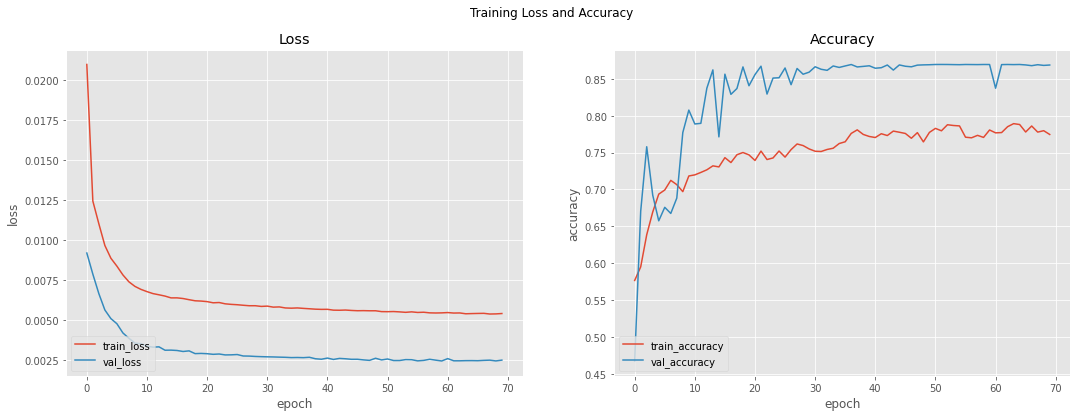

In [17]:
plot_prediction(trained_model_autoencoder_)

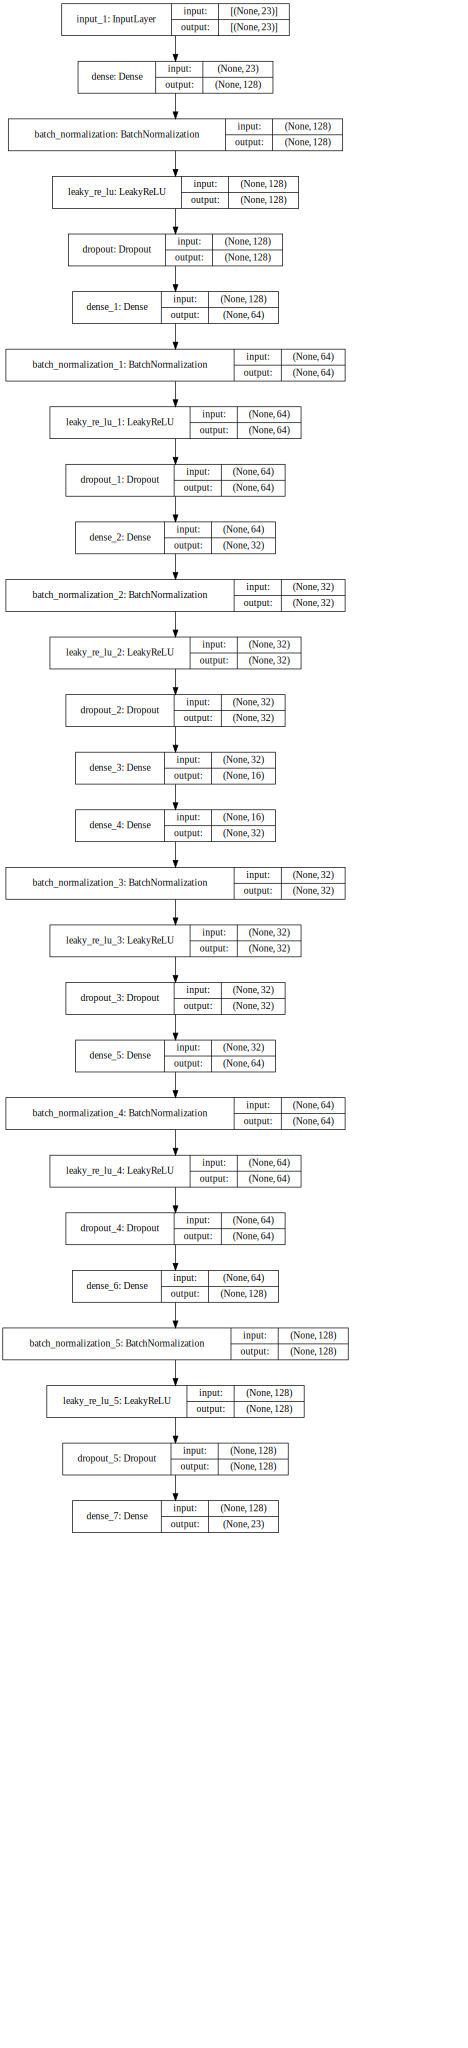

In [18]:
from keras.utils.vis_utils import model_to_dot
from IPython.display import SVG

SVG(model_to_dot(autoencoder_, show_shapes=True, show_layer_names=True, rankdir='TB').create(prog='dot', format='svg'))

In [19]:
autoencoder_._name = 'autoencoder_model'
autoencoder_.summary()

Model: "autoencoder_model"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_1 (InputLayer)         [(None, 23)]              0         
_________________________________________________________________
dense (Dense)                (None, 128)               3072      
_________________________________________________________________
batch_normalization (BatchNo (None, 128)               512       
_________________________________________________________________
leaky_re_lu (LeakyReLU)      (None, 128)               0         
_________________________________________________________________
dropout (Dropout)            (None, 128)               0         
_________________________________________________________________
dense_1 (Dense)              (None, 64)                8256      
_________________________________________________________________
batch_normalization_1 (Batch (None, 64)          

### Evaluation

In [20]:
loss, accuracy = autoencoder_.evaluate(test, test, verbose=0)

print("Final loss in test data:", loss)
print("Final accuracy in test data:", accuracy)

[codecarbon INFO @ 19:40:26] Energy consumed for RAM : 0.005486 kWh. RAM Power : 11.759872913360596 W
[codecarbon INFO @ 19:40:26] Energy consumed for all CPUs : 0.019831 kWh. All CPUs Power : 42.5 W
[codecarbon INFO @ 19:40:26] 0.025317 kWh of electricity used since the begining.


Final loss in test data: 0.0024974187836050987
Final accuracy in test data: 0.868098258972168


In [22]:
# Compression ratio

compression_ratio = (23) / np.prod(autoencoder_.get_layer('dense_7').output_shape[1:])

print(f"Ratio de compresión: {compression_ratio:.2f}")

Ratio de compresión: 1.00


[codecarbon INFO @ 19:41:41] Energy consumed for RAM : 0.005731 kWh. RAM Power : 11.759872913360596 W
[codecarbon INFO @ 19:41:41] Energy consumed for all CPUs : 0.020716 kWh. All CPUs Power : 42.5 W
[codecarbon INFO @ 19:41:41] 0.026447 kWh of electricity used since the begining.


#### Encoder

In [23]:
encoder = Model(autoencoder_.input, autoencoder_.layers[13].output)
encoder.summary()

Model: "model_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_1 (InputLayer)         [(None, 23)]              0         
_________________________________________________________________
dense (Dense)                (None, 128)               3072      
_________________________________________________________________
batch_normalization (BatchNo (None, 128)               512       
_________________________________________________________________
leaky_re_lu (LeakyReLU)      (None, 128)               0         
_________________________________________________________________
dropout (Dropout)            (None, 128)               0         
_________________________________________________________________
dense_1 (Dense)              (None, 64)                8256      
_________________________________________________________________
batch_normalization_1 (Batch (None, 64)                256 

[codecarbon INFO @ 19:41:56] Energy consumed for RAM : 0.005780 kWh. RAM Power : 11.759872913360596 W
[codecarbon INFO @ 19:41:56] Energy consumed for all CPUs : 0.020893 kWh. All CPUs Power : 42.5 W
[codecarbon INFO @ 19:41:56] 0.026673 kWh of electricity used since the begining.
[codecarbon INFO @ 19:42:11] Energy consumed for RAM : 0.005829 kWh. RAM Power : 11.759872913360596 W
[codecarbon INFO @ 19:42:11] Energy consumed for all CPUs : 0.021070 kWh. All CPUs Power : 42.5 W
[codecarbon INFO @ 19:42:11] 0.026899 kWh of electricity used since the begining.


## Part 2: Content-Based Recommender

### Preprocess data and encoding

In [93]:
pdwm_10k = playlists_dataset_with_mood.sample(n=50000, random_state=12)

mask = pdwm_10k['pid'].duplicated(keep=False)
pdwm_10k_filtered = pdwm_10k[mask]

pdwm_10k_filtered.shape

(45464, 30)

In [94]:
train_r, val_test_r = train_test_split(pdwm_10k_filtered, test_size=0.3, random_state=10, stratify = pdwm_10k_filtered['pid'])

In [113]:
train_r

,pid,pos,name,description,modified_at,num_tracks,num_albums,num_followers,num_edits,artist_name,...,instrumentalness,liveness,valence,tempo,duration_ms,time_signature,album_release_date,track_popularity,track_explicit,mood
112879,64725,96,ACL 2014,NaN,1404345600,246,114,1,14,AFI,...,0.000160,0.1240,0.672,121.836,190493,4,2003,62.0,False,Sad
1078162,631247,105,Forever,NaN,1509321600,133,85,2,14,J. Cole,...,0.000000,0.6890,0.482,81.004,278573,4,2013-06-14,19.0,True,Sad
48661,11747,139,favorite,NaN,1504742400,142,120,1,36,Kendrick Lamar,...,0.000054,0.0958,0.421,150.011,177000,4,2017-04-14,85.0,True,Energetic
310532,146743,12,Workout,NaN,1508198400,80,62,1,17,Chevelle,...,0.000060,0.2040,0.289,95.023,223173,3,1999-09-09,0.0,False,Sad
651937,308780,64,Cumbia Mix,NaN,1501027200,96,71,1,4,Los Yaguaru,...,0.000000,0.1050,0.946,171.616,224667,4,2002-01-01,0.0,False,Sad
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1003982,574085,2,Stuff I like,NaN,1509235200,54,48,1,8,Shawn Mendes,...,0.000000,0.0486,0.764,149.882,206880,4,2015-04-13,0.0,False,Energetic
580951,282746,15,summer 17,NaN,1508112000,92,75,4,45,Lil Uzi Vert,...,0.000000,0.2080,0.398,139.952,175203,4,2016-08-10,67.0,True,Anxious
1218076,834411,18,oldies,NaN,1509408000,49,48,1,34,Calvin Harris,...,0.000001,0.2540,0.511,104.066,230813,4,2017-06-30,74.0,True,Sad
467137,198992,111,Christmas,NaN,1448323200,113,43,1,5,Dave Koz,...,0.000074,0.1100,0.737,96.973,251320,4,2014-01-01,2.0,False,Sad


In [114]:
train_r = train_r.reset_index(drop=True)

[codecarbon INFO @ 20:34:26] Energy consumed for RAM : 0.016066 kWh. RAM Power : 11.759872913360596 W
[codecarbon INFO @ 20:34:26] Energy consumed for all CPUs : 0.058075 kWh. All CPUs Power : 42.5 W
[codecarbon INFO @ 20:34:26] 0.074141 kWh of electricity used since the begining.


In [116]:
pdwm_10k_filteredT = train_r.copy()

mean_popularity = df_songs_clean['track_popularity'].mean()
pdwm_10k_filteredT.loc[:, 'track_popularity'] = pdwm_10k_filteredT['track_popularity'].fillna(mean_popularity)

pdwm_10k_filteredT.loc[:, 'track_explicit'] = pdwm_10k_filteredT['track_explicit'].fillna(False)

pdwm_10k_filteredT.loc[:, 'track_explicit'] = pdwm_10k_filteredT['track_explicit'].astype(int)

# encode the moods as one-hot vectors
one_hot_encoder = OneHotEncoder()
mood_to_encoder_r = one_hot_encoder.fit_transform(pdwm_10k_filteredT[["mood"]])

# convert the encoded moods to a dataframe
mood_df_r = pd.DataFrame(mood_to_encoder_r.toarray(), columns=one_hot_encoder.get_feature_names(["mood"]))

# index reset
mood_df_r = mood_df_r.reset_index(drop=True)
pdwm_10k_filteredT = pdwm_10k_filteredT.reset_index(drop=True)

# concatenate the encoded moods to the original dataframe
df_songs_to_encode_r = pd.concat([pdwm_10k_filteredT, mood_df_r], axis=1)

In [117]:
df_unique_songs = df_songs_to_encode_r.drop_duplicates(['track_uri'])

df_tracks = df_songs_to_encode_r['track_uri']
df_track_names = df_songs_to_encode_r['track_name']

train_clean_r = df_songs_to_encode_r.drop(columns=[
    'pid', 'pos', 'name', 'description', 'modified_at', 'num_tracks','num_albums','num_followers',
    'num_edits', 'artist_name', 'track_name','album_name', 'track_uri','album_release_date', 'mood'])

In [118]:
t_scaler = MinMaxScaler()
t_scaler.fit(train_clean_r)
t_songs_scaled = t_scaler.transform(train_clean_r)

[codecarbon INFO @ 20:34:41] Energy consumed for RAM : 0.016115 kWh. RAM Power : 11.759872913360596 W
[codecarbon INFO @ 20:34:41] Energy consumed for all CPUs : 0.058252 kWh. All CPUs Power : 42.5 W
[codecarbon INFO @ 20:34:41] 0.074367 kWh of electricity used since the begining.


In [119]:
print(val_test_r.shape)
print(train_r.shape)
print(t_songs_scaled.shape)

(13640, 30)
(31824, 30)
(31824, 23)


After encoding the data with the encoder, we are left with a lower-dimensional representation of the original data, which still contains the most important features of the songs. 

In [120]:
# Encode
encoded_data = encoder.predict(t_songs_scaled)

In [121]:
encoded_data.shape

(31824, 16)

### Cosine Similarity Matrix

In [122]:
train_scaled_cos_matrix = cosine_similarity(encoded_data)

In [123]:
train_scaled_cos_matrix.shape

(31824, 31824)

In [124]:
def cos_similar_songs_playlist(cos_matrix, target_playlist_id, cand_list_size):
    """
    Generates a list of cosine-similar songs for a given target playlist.

    Parameters:
        cos_matrix (ndarray): The cosine similarity matrix.
        target_playlist_id (int): The ID of the target playlist.
        cand_list_size (int): The desired size of the candidate song list.

    Returns:
        list: A list of cosine-similar songs.

    """
    target_track_inx = np.where(train_r["pid"] == target_playlist_id)[0] # index of tracks in training playlist of target playlist
    candidate_cos_matrix = cos_matrix

    ## For each song in the playlist, find k similar songs
    cand_list = []
    # cand_list_size = k*15
    k = np.floor(cand_list_size/len(target_track_inx)) # round(cand_list_size/len(target_track_inx))
    k_rest = cand_list_size - k*len(target_track_inx)
    # e.g., for a candidate list size of 30, get 3 songs for each track first
    for inx, i in enumerate(target_track_inx):
        candidate_song_rec = candidate_cos_matrix[i, ] #ith row of matrix
        candidate_song_rec_inx = np.argsort(candidate_song_rec)
        unique_candidate_song_sorted = train_r['track_uri'][candidate_song_rec_inx][::-1].drop_duplicates()
        tracks_in_target_playlist = train_r.loc[train_r["pid"] == target_playlist_id, "track_uri"]
        song_to_recommend = np.array(unique_candidate_song_sorted.loc[~unique_candidate_song_sorted.isin(tracks_in_target_playlist)])

        if (k_rest != 0 & inx <= k_rest): # 30-24 = 6; for the first 6 tracks recommend k + 1 songs
            k_song_to_recommend = song_to_recommend[:int(k+1)]
        else:
            k_song_to_recommend = song_to_recommend[:int(k)]
            
        if inx == 0:
            cand_list = k_song_to_recommend
        else:
            cand_list = np.append(cand_list, k_song_to_recommend)
    return list(cand_list) # turn np array into list

##  Model Performance Metrics

In [125]:
def nholdout(playlist_id, df):
    """
    Returns the number of songs held out in the validation/test set for a given playlist ID.

    Parameters:
        playlist_id (int): The ID of the playlist.
        df (pandas.DataFrame): The DataFrame containing the playlist data.

    Returns:
        int: The number of songs held out in the validation/test set.

    """
    return len(df[df.pid == playlist_id].track_uri)

In [126]:
def r_precision(predictions, val_set):
    """
    Computes the R-Precision score for a given playlist prediction set.

    Parameters:
        predictions (list or numpy.ndarray): A list or 1-D numpy array containing the predicted track URIs.
        val_set (pandas.Series): A pandas Series representing the ground truth track URIs for the validation set.

    Returns:
        float: The R-Precision score.

    """
    if val_set.shape[0] > 0:
        score = np.sum(val_set.isin(predictions))/val_set.shape[0]
    else:
        score = 0.0
    return score

In [127]:
def dcg_at_k(r, k, method=0):
    """
    Computes the Discounted Cumulative Gain (DCG) at a specified rank `k` given a list of relevance scores.

    Parameters:
        r (list or numpy.ndarray): A list or 1-D numpy array containing the relevance scores.
        k (int): The rank at which to compute the DCG.
        method (int, optional): The formula to use for computing the DCG. 0 for the default formula, 1 for the alternative formula. Default is 0.

    Returns:
        float: The DCG at rank `k`.

    Raises:
        ValueError: If `method` is not 0 or 1.

    """
    r = np.asfarray(r)[:k]
    if r.size:
        if method == 0:
            return r[0] + np.sum(r[1:] / np.log2(np.arange(2, r.size + 1)))
        elif method == 1:
            return np.sum(r / np.log2(np.arange(2, r.size + 2)))
        else:
            raise ValueError('method must be 0 or 1.')
    return 0.


def ndcg_at_k(r, k, method=0):
    """
    Computes the Normalized Discounted Cumulative Gain (NDCG) at a specified rank `k` given a list of relevance scores.

    Parameters:
        r (list or numpy.ndarray): A list or 1-D numpy array containing the relevance scores.
        k (int): The rank at which to compute the NDCG.
        method (int, optional): The formula to use for computing the NDCG. 0 for the default formula, 1 for the alternative formula. Default is 0.

    Returns:
        float: The NDCG at rank `k`.

    """
    dcg_max = dcg_at_k(sorted(r, reverse=True), k, method)
    if not dcg_max:
        return 0.
    return dcg_at_k(r, k, method) / dcg_max

In [128]:
unique_playlistid = train_r['pid'].drop_duplicates()

In [129]:
rps = []
ndcgs = []
for pid in unique_playlistid:
    ps = cos_similar_songs_playlist(train_scaled_cos_matrix, pid, nholdout(pid, val_test_r)*15)
    vs = val_test_r[val_test_r.pid == pid].track_uri
    rps.append(r_precision(ps, vs))
    
    r = np.zeros(len(ps))
    for i, p in enumerate(ps):
        if np.any(vs.isin([p])):
            r[i] = 1
    ndcgs.append(ndcg_at_k(r, len(r)))

[codecarbon INFO @ 20:34:56] Energy consumed for RAM : 0.016164 kWh. RAM Power : 11.759872913360596 W
[codecarbon INFO @ 20:34:56] Energy consumed for all CPUs : 0.058429 kWh. All CPUs Power : 42.5 W
[codecarbon INFO @ 20:34:56] 0.074593 kWh of electricity used since the begining.
[codecarbon INFO @ 20:35:11] Energy consumed for RAM : 0.016213 kWh. RAM Power : 11.759872913360596 W
[codecarbon INFO @ 20:35:11] Energy consumed for all CPUs : 0.058606 kWh. All CPUs Power : 42.5 W
[codecarbon INFO @ 20:35:11] 0.074819 kWh of electricity used since the begining.
[codecarbon INFO @ 20:35:26] Energy consumed for RAM : 0.016262 kWh. RAM Power : 11.759872913360596 W
[codecarbon INFO @ 20:35:26] Energy consumed for all CPUs : 0.058783 kWh. All CPUs Power : 42.5 W
[codecarbon INFO @ 20:35:26] 0.075045 kWh of electricity used since the begining.
[codecarbon INFO @ 20:35:41] Energy consumed for RAM : 0.016311 kWh. RAM Power : 11.759872913360596 W
[codecarbon INFO @ 20:35:41] Energy consumed for all

[codecarbon INFO @ 20:42:11] Energy consumed for all CPUs : 0.063564 kWh. All CPUs Power : 42.5 W
[codecarbon INFO @ 20:42:11] 0.081148 kWh of electricity used since the begining.
[codecarbon INFO @ 20:42:26] Energy consumed for RAM : 0.017633 kWh. RAM Power : 11.759872913360596 W
[codecarbon INFO @ 20:42:26] Energy consumed for all CPUs : 0.063741 kWh. All CPUs Power : 42.5 W
[codecarbon INFO @ 20:42:26] 0.081374 kWh of electricity used since the begining.
[codecarbon INFO @ 20:42:41] Energy consumed for RAM : 0.017682 kWh. RAM Power : 11.759872913360596 W
[codecarbon INFO @ 20:42:41] Energy consumed for all CPUs : 0.063918 kWh. All CPUs Power : 42.5 W
[codecarbon INFO @ 20:42:41] 0.081600 kWh of electricity used since the begining.
[codecarbon INFO @ 20:42:56] Energy consumed for RAM : 0.017731 kWh. RAM Power : 11.759872913360596 W
[codecarbon INFO @ 20:42:56] Energy consumed for all CPUs : 0.064095 kWh. All CPUs Power : 42.5 W
[codecarbon INFO @ 20:42:56] 0.081826 kWh of electricity

In [131]:
avg_rp = np.mean(rps)
avg_ndcg = np.mean(ndcgs)

print('Avg. R-Precision: ', avg_rp)
print('Avg. NDCG: ', avg_ndcg)

print('Total Sum: ', np.mean([avg_rp, avg_ndcg]))

Avg. R-Precision:  0.003109996961409906
Avg. NDCG:  0.0015399342342090135
Total Sum:  0.00232496559780946


[codecarbon INFO @ 20:44:26] Energy consumed for RAM : 0.018025 kWh. RAM Power : 11.759872913360596 W
[codecarbon INFO @ 20:44:26] Energy consumed for all CPUs : 0.065157 kWh. All CPUs Power : 42.5 W
[codecarbon INFO @ 20:44:26] 0.083183 kWh of electricity used since the begining.
[codecarbon INFO @ 20:44:41] Energy consumed for RAM : 0.018074 kWh. RAM Power : 11.759872913360596 W
[codecarbon INFO @ 20:44:41] Energy consumed for all CPUs : 0.065335 kWh. All CPUs Power : 42.5 W
[codecarbon INFO @ 20:44:41] 0.083409 kWh of electricity used since the begining.
[codecarbon INFO @ 20:44:56] Energy consumed for RAM : 0.018123 kWh. RAM Power : 11.759872913360596 W
[codecarbon INFO @ 20:44:56] Energy consumed for all CPUs : 0.065512 kWh. All CPUs Power : 42.5 W
[codecarbon INFO @ 20:44:56] 0.083635 kWh of electricity used since the begining.


In [132]:
experiment.end()

[codecarbon INFO @ 20:45:06] Energy consumed for RAM : 0.018156 kWh. RAM Power : 11.759872913360596 W
[codecarbon INFO @ 20:45:06] Energy consumed for all CPUs : 0.065629 kWh. All CPUs Power : 42.5 W
[codecarbon INFO @ 20:45:06] 0.083785 kWh of electricity used since the begining.
COMET INFO: ---------------------------------------------------------------------------------------
COMET INFO: Comet.ml Experiment Summary
COMET INFO: ---------------------------------------------------------------------------------------
COMET INFO:   Data:
COMET INFO:     display_summary_level : 1
COMET INFO:     url                   : https://www.comet.com/sadcor/general/9f3c6c3e73894ded991bf51e75072ec1
COMET INFO:   Metrics [count] (min, max):
COMET INFO:     accuracy [70]                  : (0.5766087174415588, 0.7892806529998779)
COMET INFO:     batch_accuracy [46970]         : (0.05113636329770088, 0.90625)
COMET INFO:     batch_loss [46970]             : (0.003835004288703203, 0.21519538760185242)
C